In [7]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
import os
import warnings
import time

from packages import v2tools
from packages import v2models

from sklearn import metrics

warnings.filterwarnings("ignore")

In [8]:
# Read in the datasets
prices = v2tools.read_price_data()

ida_prices = v2tools.read_intraday_price_data()

fuel_mix = v2tools.read_fuel_mix_data()

wind_forecast = v2tools.read_forecast_data("Wind")
demand_forecast = v2tools.read_forecast_data("Demand")
solar_forecast = v2tools.read_forecast_data("Solar")
gas_price = v2tools.read_gas_price_data()

planned = pd.concat([wind_forecast, demand_forecast, solar_forecast], axis=1)

Available columns in the CSV file: ['auction', 'DeliveryPeriod', 'EURPrices', 'price_gbp', 'ni_vols', 'ni_netpos', 'roi_vols', 'roi_netpos', 'DeliveryDate', 'DeliveryHour', 'DeliveryInterval', 'semo_vols', 'doy', 'dow', 'week', 'dom', 'Month', 'year']


In [9]:
# Define the common date range
common_start_date = pd.Timestamp('2022-09-01 01:00:00')
common_end_date = pd.Timestamp('2023-09-30 23:00:00')

In [10]:
# Trim the datasets to the common date range
prices = prices.loc[common_start_date:common_end_date]
ida_prices = ida_prices.loc[common_start_date:common_end_date]
planned = planned.loc[common_start_date:common_end_date]
fuel_mix = fuel_mix.loc[common_start_date:common_end_date]
gas_price = gas_price.loc[common_start_date:common_end_date]

In [5]:
# Log to check indexes of trimmed datasets
print("Prices Index Range:", prices.index.min(), prices.index.max())
print("IDA Prices Index Range:", ida_prices.index.min(), ida_prices.index.max())
print("Planned Index Range:", planned.index.min(), planned.index.max())
print("Fuel Mix Index Range:", fuel_mix.index.min(), fuel_mix.index.max())
print("Gas Price Index Range:", gas_price.index.min(), gas_price.index.max())

Prices Index Range: 2022-09-01 01:00:00 2023-09-30 23:00:00
IDA Prices Index Range: 2022-09-01 01:00:00 2023-09-29 23:00:00
Planned Index Range: 2022-09-01 01:00:00 2023-09-30 23:00:00
Fuel Mix Index Range: 2022-09-01 01:00:00 2023-09-30 23:00:00
Gas Price Index Range: 2022-09-01 01:00:00 2023-09-30 23:00:00


In [8]:
extra_dates_in_df1 = fuel_mix.index.difference(gas_price.index)
extra_rows_df1 = fuel_mix.loc[extra_dates_in_df1]
print(extra_rows_df1)

Empty DataFrame
Columns: [Battery, CCGT, CHP, DSR, Hydro, Interconnectors, OCGT, Oil, Peat, Pumped_Storage, Solar_Actual, Waste, Wind_Actual]
Index: []


In [11]:
importlib.reload(tools)
importlib.reload(models)

naive_1d = models.naive(1, "D")
naive_7d = models.naive(7, "D")
naive_1y = models.naive(1, "Y")

_, res_naive1d, rmse_naive1d, mae_naive1d = tools.walk_forward_evaluation(naive_1d, price_data=prices, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))
_, res_naive7d, rmse_naive7d, mae_naive7d = tools.walk_forward_evaluation(naive_7d, price_data=prices, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))
_, res_naive1y, rmse_naive1y, mae_naive1y = tools.walk_forward_evaluation(naive_1y, price_data=prices, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))

AttributeError: 'NoneType' object has no attribute 'loc'

In [8]:
print("RMSEs:")
print(f"naive_1d: {rmse_naive1d.round(2)}")
print(f"naive_7d: {rmse_naive7d.round(2)}")
print(f"naive_1y: {rmse_naive1y.round(2)}")
print("\nMAEs:")
print(f"naive_1d: {mae_naive1d.round(2)}")
print(f"naive_7d: {mae_naive7d.round(2)}")
print(f"naive_1y: {mae_naive1y.round(2)}")

RMSEs:
naive_1d: 34.01

MAEs:
naive_1d: 23.05


In [6]:
#Random Forest 

importlib.reload(v2tools)
importlib.reload(v2models)

model_params = {
    "n_estimators": 600,
    "max_depth": 35,
    "max_features": 15,
    "n_jobs": -1
}

lag_params = {
    "price_lags": [24,48,72,96],
    "ida_price_lags": [24,48],
    "planned_lags": [0,24],
    "fuel_mix_lags": [24,48],
    "gas_price_lags": [1,24,48]
}

rf_model = v2models.random_forest(model_params, lag_params)
rf_model, rf_res, rf_rmse, rf_mae = v2tools.walk_forward_evaluation(rf_model, prices, ida_prices, planned, fuel_mix, gas_price, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))

Initial setup complete.
Train Price Data Index: DatetimeIndex(['2022-09-01 01:00:00', '2022-09-01 02:00:00',
               '2022-09-01 03:00:00', '2022-09-01 04:00:00',
               '2022-09-01 05:00:00', '2022-09-01 06:00:00',
               '2022-09-01 07:00:00', '2022-09-01 08:00:00',
               '2022-09-01 09:00:00', '2022-09-01 10:00:00',
               ...
               '2023-07-31 14:00:00', '2023-07-31 15:00:00',
               '2023-07-31 16:00:00', '2023-07-31 17:00:00',
               '2023-07-31 18:00:00', '2023-07-31 19:00:00',
               '2023-07-31 20:00:00', '2023-07-31 21:00:00',
               '2023-07-31 22:00:00', '2023-07-31 23:00:00'],
              dtype='datetime64[ns]', name='DeliveryPeriod', length=8015, freq=None)
Train IDA Data Index: DatetimeIndex(['2022-09-01 01:00:00', '2022-09-01 02:00:00',
               '2022-09-01 03:00:00', '2022-09-01 04:00:00',
               '2022-09-01 05:00:00', '2022-09-01 06:00:00',
               '2022-09-01 07:00

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

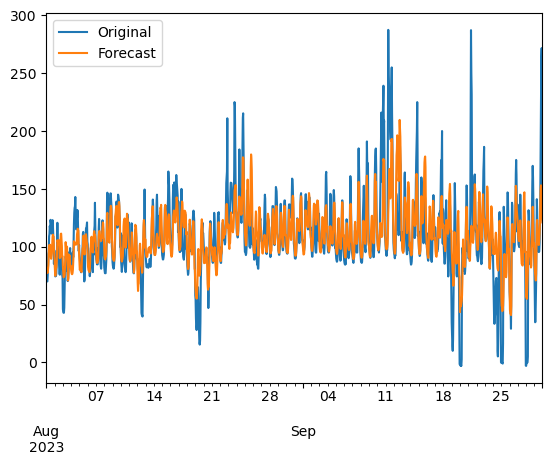

In [10]:
rf_res.plot()
plt.show()

In [11]:
print("RF:")
print("RMSE:", rf_rmse)
print("MAE:", rf_mae)

RF:
RMSE: 23.731197768957077
MAE: 15.263812757628072


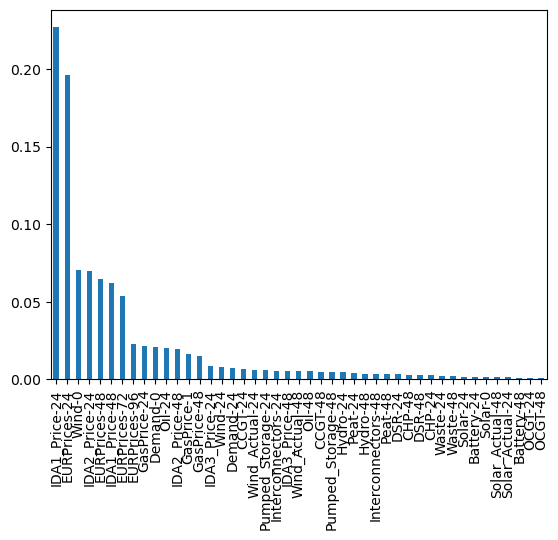

In [8]:
rf_model.variable_importances.mean(axis=1).sort_values(ascending=False).plot.bar()
plt.show()

In [ ]:
#AR Model

importlib.reload(tools)
importlib.reload(models)

lag_dependencies = [list(range(24,n*24+1,24)) for n in range(1,8)]

model_params = {
    "lags": lag_dependencies,
    "trend": "ct",
    "ic": "aic",
    "exog": False,
}

lag_params = {
    "ida_price_lags": [24,48],
    "planned_lags": [0,24],
    "fuel_mix_lags": [24,48],
    "gas_price_lags": [1,24,48]
}

ar_model = models.ARX(model_params, lag_params)
ar_model, ar_res, ar_rmse, ar_mae = tools.walk_forward_evaluation(ar_model, prices, ida_prices, planned, fuel_mix, gas_price, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))

In [ ]:
ar_res.plot()
plt.show()

In [ ]:
print("AR:")
print("RMSE:", ar_rmse)
print("MAE:", ar_mae)

In [7]:
#ARX

importlib.reload(v2tools)
importlib.reload(v2models)

lag_dependencies = [list(range(24,n*24+1,24)) for n in range(1,8)]

model_params = {
    "lags": lag_dependencies,
    "trend": "ct",
    "ic": "aic",
    "exog": True,
}

lag_params = {
    "ida_price_lags": [24,48],
    "planned_lags": [0,24],
    "fuel_mix_lags": [24,48],
    "gas_price_lags": [1,24,48]
}

arx_model = v2models.ARX(model_params, lag_params)
arx_model, arx_res, arx_rmse, arx_mae = v2tools.walk_forward_evaluation(arx_model, prices, ida_prices, planned, fuel_mix, gas_price, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))

Initial setup complete.
Train Price Data Index: DatetimeIndex(['2022-09-01 01:00:00', '2022-09-01 02:00:00',
               '2022-09-01 03:00:00', '2022-09-01 04:00:00',
               '2022-09-01 05:00:00', '2022-09-01 06:00:00',
               '2022-09-01 07:00:00', '2022-09-01 08:00:00',
               '2022-09-01 09:00:00', '2022-09-01 10:00:00',
               ...
               '2023-07-31 14:00:00', '2023-07-31 15:00:00',
               '2023-07-31 16:00:00', '2023-07-31 17:00:00',
               '2023-07-31 18:00:00', '2023-07-31 19:00:00',
               '2023-07-31 20:00:00', '2023-07-31 21:00:00',
               '2023-07-31 22:00:00', '2023-07-31 23:00:00'],
              dtype='datetime64[ns]', name='DeliveryPeriod', length=8015, freq=None)
Train IDA Data Index: DatetimeIndex(['2022-09-01 01:00:00', '2022-09-01 02:00:00',
               '2022-09-01 03:00:00', '2022-09-01 04:00:00',
               '2022-09-01 05:00:00', '2022-09-01 06:00:00',
               '2022-09-01 07:00

Current iteration: 4
Forecast index: DatetimeIndex(['2023-08-05 00:00:00', '2023-08-05 01:00:00',
               '2023-08-05 02:00:00', '2023-08-05 03:00:00',
               '2023-08-05 04:00:00', '2023-08-05 05:00:00',
               '2023-08-05 06:00:00', '2023-08-05 07:00:00',
               '2023-08-05 08:00:00', '2023-08-05 09:00:00',
               '2023-08-05 10:00:00', '2023-08-05 11:00:00',
               '2023-08-05 12:00:00', '2023-08-05 13:00:00',
               '2023-08-05 14:00:00', '2023-08-05 15:00:00',
               '2023-08-05 16:00:00', '2023-08-05 17:00:00',
               '2023-08-05 18:00:00', '2023-08-05 19:00:00',
               '2023-08-05 20:00:00', '2023-08-05 21:00:00',
               '2023-08-05 22:00:00', '2023-08-05 23:00:00'],
              dtype='datetime64[ns]', freq=None)
Forecast values: [[ 76.62058266]
 [ 74.70023999]
 [ 76.21686188]
 [ 71.14097713]
 [ 69.51933627]
 [ 63.15916562]
 [ 54.43786392]
 [ 50.05444905]
 [ 45.75309325]
 [ 47.46024606]
 [ 5

Current iteration: 11
Forecast index: DatetimeIndex(['2023-08-12 00:00:00', '2023-08-12 01:00:00',
               '2023-08-12 02:00:00', '2023-08-12 03:00:00',
               '2023-08-12 04:00:00', '2023-08-12 05:00:00',
               '2023-08-12 06:00:00', '2023-08-12 07:00:00',
               '2023-08-12 08:00:00', '2023-08-12 09:00:00',
               '2023-08-12 10:00:00', '2023-08-12 11:00:00',
               '2023-08-12 12:00:00', '2023-08-12 13:00:00',
               '2023-08-12 14:00:00', '2023-08-12 15:00:00',
               '2023-08-12 16:00:00', '2023-08-12 17:00:00',
               '2023-08-12 18:00:00', '2023-08-12 19:00:00',
               '2023-08-12 20:00:00', '2023-08-12 21:00:00',
               '2023-08-12 22:00:00', '2023-08-12 23:00:00'],
              dtype='datetime64[ns]', freq=None)
Forecast values: [[ 52.01004396]
 [ 43.87818381]
 [ 39.31641361]
 [ 39.84943228]
 [ 46.29537166]
 [ 55.62809505]
 [ 67.50044298]
 [ 75.68588433]
 [ 74.15659598]
 [ 70.63704572]
 [ 

Current iteration: 18
Forecast index: DatetimeIndex(['2023-08-19 00:00:00', '2023-08-19 01:00:00',
               '2023-08-19 02:00:00', '2023-08-19 03:00:00',
               '2023-08-19 04:00:00', '2023-08-19 05:00:00',
               '2023-08-19 06:00:00', '2023-08-19 07:00:00',
               '2023-08-19 08:00:00', '2023-08-19 09:00:00',
               '2023-08-19 10:00:00', '2023-08-19 11:00:00',
               '2023-08-19 12:00:00', '2023-08-19 13:00:00',
               '2023-08-19 14:00:00', '2023-08-19 15:00:00',
               '2023-08-19 16:00:00', '2023-08-19 17:00:00',
               '2023-08-19 18:00:00', '2023-08-19 19:00:00',
               '2023-08-19 20:00:00', '2023-08-19 21:00:00',
               '2023-08-19 22:00:00', '2023-08-19 23:00:00'],
              dtype='datetime64[ns]', freq=None)
Forecast values: [[ 40.76092431]
 [ 39.87841336]
 [ 39.04086314]
 [ 37.35412878]
 [ 34.78578651]
 [ 34.49666136]
 [ 50.5005607 ]
 [ 58.24858564]
 [ 68.89742112]
 [ 56.53636938]
 [ 

Current iteration: 25
Forecast index: DatetimeIndex(['2023-08-26 00:00:00', '2023-08-26 01:00:00',
               '2023-08-26 02:00:00', '2023-08-26 03:00:00',
               '2023-08-26 04:00:00', '2023-08-26 05:00:00',
               '2023-08-26 06:00:00', '2023-08-26 07:00:00',
               '2023-08-26 08:00:00', '2023-08-26 09:00:00',
               '2023-08-26 10:00:00', '2023-08-26 11:00:00',
               '2023-08-26 12:00:00', '2023-08-26 13:00:00',
               '2023-08-26 14:00:00', '2023-08-26 15:00:00',
               '2023-08-26 16:00:00', '2023-08-26 17:00:00',
               '2023-08-26 18:00:00', '2023-08-26 19:00:00',
               '2023-08-26 20:00:00', '2023-08-26 21:00:00',
               '2023-08-26 22:00:00', '2023-08-26 23:00:00'],
              dtype='datetime64[ns]', freq=None)
Forecast values: [[ 88.45972259]
 [ 88.21314665]
 [ 85.65417638]
 [ 83.7634022 ]
 [ 81.67266713]
 [ 84.66696658]
 [ 98.38307744]
 [109.19172966]
 [112.86571286]
 [102.14053233]
 [ 

Current iteration: 32
Forecast index: DatetimeIndex(['2023-09-02 00:00:00', '2023-09-02 01:00:00',
               '2023-09-02 02:00:00', '2023-09-02 03:00:00',
               '2023-09-02 04:00:00', '2023-09-02 05:00:00',
               '2023-09-02 06:00:00', '2023-09-02 07:00:00',
               '2023-09-02 08:00:00', '2023-09-02 09:00:00',
               '2023-09-02 10:00:00', '2023-09-02 11:00:00',
               '2023-09-02 12:00:00', '2023-09-02 13:00:00',
               '2023-09-02 14:00:00', '2023-09-02 15:00:00',
               '2023-09-02 16:00:00', '2023-09-02 17:00:00',
               '2023-09-02 18:00:00', '2023-09-02 19:00:00',
               '2023-09-02 20:00:00', '2023-09-02 21:00:00',
               '2023-09-02 22:00:00', '2023-09-02 23:00:00'],
              dtype='datetime64[ns]', freq=None)
Forecast values: [[127.36986354]
 [125.01780361]
 [123.4825138 ]
 [121.32658034]
 [119.75895919]
 [122.45437657]
 [133.13731238]
 [148.26270732]
 [149.14746645]
 [136.7593533 ]
 [1

Current iteration: 39
Forecast index: DatetimeIndex(['2023-09-09 00:00:00', '2023-09-09 01:00:00',
               '2023-09-09 02:00:00', '2023-09-09 03:00:00',
               '2023-09-09 04:00:00', '2023-09-09 05:00:00',
               '2023-09-09 06:00:00', '2023-09-09 07:00:00',
               '2023-09-09 08:00:00', '2023-09-09 09:00:00',
               '2023-09-09 10:00:00', '2023-09-09 11:00:00',
               '2023-09-09 12:00:00', '2023-09-09 13:00:00',
               '2023-09-09 14:00:00', '2023-09-09 15:00:00',
               '2023-09-09 16:00:00', '2023-09-09 17:00:00',
               '2023-09-09 18:00:00', '2023-09-09 19:00:00',
               '2023-09-09 20:00:00', '2023-09-09 21:00:00',
               '2023-09-09 22:00:00', '2023-09-09 23:00:00'],
              dtype='datetime64[ns]', freq=None)
Forecast values: [[115.68334938]
 [109.89825489]
 [108.91634271]
 [108.59913962]
 [105.52110785]
 [116.13738263]
 [125.71367392]
 [141.54764297]
 [135.71534725]
 [129.87379514]
 [1

Current iteration: 46
Forecast index: DatetimeIndex(['2023-09-16 00:00:00', '2023-09-16 01:00:00',
               '2023-09-16 02:00:00', '2023-09-16 03:00:00',
               '2023-09-16 04:00:00', '2023-09-16 05:00:00',
               '2023-09-16 06:00:00', '2023-09-16 07:00:00',
               '2023-09-16 08:00:00', '2023-09-16 09:00:00',
               '2023-09-16 10:00:00', '2023-09-16 11:00:00',
               '2023-09-16 12:00:00', '2023-09-16 13:00:00',
               '2023-09-16 14:00:00', '2023-09-16 15:00:00',
               '2023-09-16 16:00:00', '2023-09-16 17:00:00',
               '2023-09-16 18:00:00', '2023-09-16 19:00:00',
               '2023-09-16 20:00:00', '2023-09-16 21:00:00',
               '2023-09-16 22:00:00', '2023-09-16 23:00:00'],
              dtype='datetime64[ns]', freq=None)
Forecast values: [[ 90.27116479]
 [ 83.64927044]
 [ 73.62340536]
 [ 65.2692584 ]
 [ 60.2075983 ]
 [ 70.38909521]
 [ 82.64577673]
 [101.08312641]
 [102.8893865 ]
 [ 89.61546642]
 [ 

Current iteration: 53
Forecast index: DatetimeIndex(['2023-09-23 00:00:00', '2023-09-23 01:00:00',
               '2023-09-23 02:00:00', '2023-09-23 03:00:00',
               '2023-09-23 04:00:00', '2023-09-23 05:00:00',
               '2023-09-23 06:00:00', '2023-09-23 07:00:00',
               '2023-09-23 08:00:00', '2023-09-23 09:00:00',
               '2023-09-23 10:00:00', '2023-09-23 11:00:00',
               '2023-09-23 12:00:00', '2023-09-23 13:00:00',
               '2023-09-23 14:00:00', '2023-09-23 15:00:00',
               '2023-09-23 16:00:00', '2023-09-23 17:00:00',
               '2023-09-23 18:00:00', '2023-09-23 19:00:00',
               '2023-09-23 20:00:00', '2023-09-23 21:00:00',
               '2023-09-23 22:00:00', '2023-09-23 23:00:00'],
              dtype='datetime64[ns]', freq=None)
Forecast values: [[121.30673605]
 [121.65690802]
 [122.02019549]
 [121.38806677]
 [124.23315955]
 [137.46479614]
 [155.68392682]
 [174.11860085]
 [160.4151414 ]
 [134.78541529]
 [1

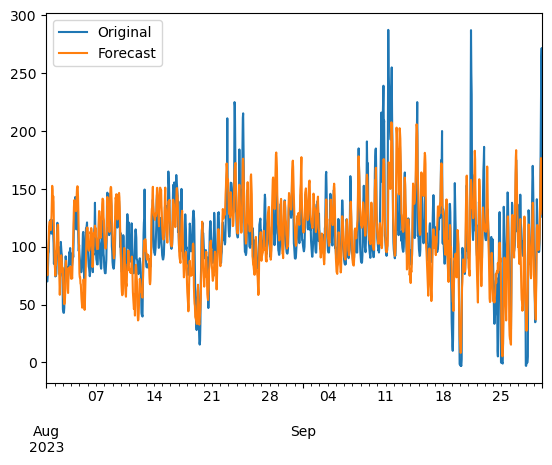

In [12]:
arx_res.plot()
plt.show()

In [13]:
print("ARX:")
print("RMSE:", arx_rmse)
print("MAE:", arx_mae)

ARX:
RMSE: 23.44926982274539
MAE: 17.59761738316699


In [9]:
#Sigmoid Feedforward Neural Network

importlib.reload(v2tools)
importlib.reload(v2models)

lag_params = {
    "price_lags": [24,48,72,96],
    "ida_price_lags": [24,48],
    "planned_lags": [0,24],
    "fuel_mix_lags": [24,48],
    "gas_price_lags": [1,24,48]
}

model_params = {
    "init_params": {
        "num_of_nodes": (len(lag_params["price_lags"])+len(lag_params["ida_price_lags"])+2*len(lag_params["planned_lags"]))/2,
        "input_cols": len(lag_params["price_lags"])+len(lag_params["ida_price_lags"])+2*len(lag_params["planned_lags"]),
        "act_fn": "sigmoid",
        "n_layers": 3,
        "opt": "adam",
        "loss": "mse"
    },
    "train_params": {
        "validation_split": 0,
        "verbose": 0
    },
    "other_params": {
        "init_epochs": 2200,
        "subseq_epochs": 500,
        "GPU": True
    }
}

sigmoid_ffnn_model = v2models.ffnn(model_params, lag_params)
sigmoid_ffnn_model, sigmoid_ffnn_res, sigmoid_ffnn_rmse, sigmoid_ffnn_mae = v2tools.walk_forward_evaluation(sigmoid_ffnn_model, prices, ida_prices, planned, fuel_mix, gas_price, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))




1/1 [==============================] - 0s 75ms/step
Finished forecast for 2023-08-01. Forecast value: 100.14741516113281.
1/1 [==============================] - 0s 56ms/step
Finished forecast for 2023-08-02. Forecast value: 138.74468994140625.
1/1 [==============================] - 0s 31ms/step
Finished forecast for 2023-08-03. Forecast value: 143.7737274169922.
1/1 [==============================] - 0s 55ms/step
Finished forecast for 2023-08-04. Forecast value: 137.02230834960938.
1/1 [==============================] - 0s 53ms/step
Finished forecast for 2023-08-05. Forecast value: 137.4839630126953.
1/1 [==============================] - 0s 51ms/step
Finished forecast for 2023-08-06. Forecast value: 145.70167541503906.
1/1 [==============================] - 0s 49ms/step
Finished forecast for 2023-08-07. Forecast value: 147.53099060058594.
1/1 [==============================] - 0s 47ms/step
Finished forecast for 2023-08-08. Forecast value: 151.0182647705078.
1/1 [===================

1/1 [==============================] - 0s 30ms/step
Finished forecast for 2023-09-21. Forecast value: 131.00270080566406.
1/1 [==============================] - 0s 46ms/step
Finished forecast for 2023-09-22. Forecast value: 133.8682098388672.
1/1 [==============================] - 0s 46ms/step
Finished forecast for 2023-09-23. Forecast value: 143.0843048095703.
1/1 [==============================] - 0s 46ms/step
Finished forecast for 2023-09-24. Forecast value: 139.66943359375.
1/1 [==============================] - 0s 47ms/step
Finished forecast for 2023-09-25. Forecast value: 132.93743896484375.
1/1 [==============================] - 0s 46ms/step
Finished forecast for 2023-09-26. Forecast value: 125.49699401855469.
1/1 [==============================] - 0s 47ms/step
Finished forecast for 2023-09-27. Forecast value: 140.54904174804688.
1/1 [==============================] - 0s 50ms/step
Finished forecast for 2023-09-28. Forecast value: 132.9042510986328.
1/1 [=========================

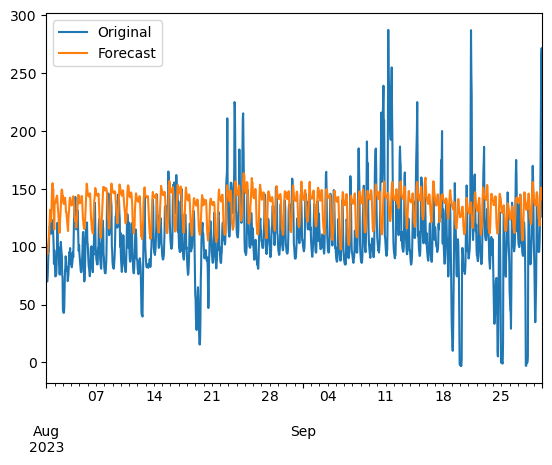

In [10]:
sigmoid_ffnn_res.plot()
plt.show()

In [11]:
print("Sigmoid FFNN:")
print("RMSE:", sigmoid_ffnn_rmse)
print("MAE:", sigmoid_ffnn_mae)

Sigmoid FFNN:
RMSE: 42.980753507609585
MAE: 34.56475540584988


In [6]:
#Tanh Feedforward Neural Network

importlib.reload(v2tools)
importlib.reload(v2models)

lag_params = {
    "price_lags": [24,48,72,96],
    "ida_price_lags": [24,48],
    "planned_lags": [0,24],
    "fuel_mix_lags": [24,48],
    "gas_price_lags": [1,24,48]
}

model_params = {
    "init_params": {
        "num_of_nodes": (len(lag_params["price_lags"])+len(lag_params["ida_price_lags"])+2*len(lag_params["planned_lags"]))/2,
        "input_cols": len(lag_params["price_lags"])+len(lag_params["ida_price_lags"])+2*len(lag_params["planned_lags"]),
        "act_fn": "tanh",
        "n_layers": 3,
        "opt": "adam",
        "loss": "mse"
    },
    "train_params": {
        "validation_split": 0,
        "verbose": 0
    },
    "other_params": {
        "init_epochs": 2200,
        "subseq_epochs": 500,
        "GPU": True
    }
}
tanh_ffnn_model = v2models.ffnn(model_params, lag_params)
tanh_ffnn_model, tanh_ffnn_res, tanh_ffnn_rmse, tanh_ffnn_mae = v2tools.walk_forward_evaluation(tanh_ffnn_model, prices, ida_prices, planned, fuel_mix, gas_price, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))


1/1 [==============================] - 0s 64ms/step
Finished forecast for 2023-08-01. Forecast value: 96.25621032714844.
1/1 [==============================] - 0s 51ms/step
Finished forecast for 2023-08-02. Forecast value: 118.29074096679688.
1/1 [==============================] - 0s 44ms/step
Finished forecast for 2023-08-03. Forecast value: 94.63531494140625.
1/1 [==============================] - 0s 47ms/step
Finished forecast for 2023-08-04. Forecast value: 83.50115966796875.
1/1 [==============================] - 0s 47ms/step
Finished forecast for 2023-08-05. Forecast value: 93.25928497314453.


KeyboardInterrupt: 

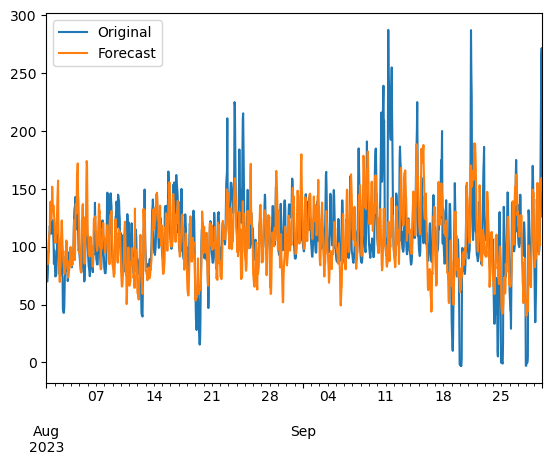

In [13]:
tanh_ffnn_res.plot()
plt.show()

In [14]:
print("Tanh FFNN:")
print("RMSE:", tanh_ffnn_rmse)
print("MAE:", tanh_ffnn_mae)

Tanh FFNN:
RMSE: 29.548979536990526
MAE: 21.586050617112054


In [5]:
#ReLU Feedforward Neural Network

importlib.reload(v2tools)
importlib.reload(v2models)

lag_params = {
    "price_lags": [24,48,72,96],
    "ida_price_lags": [24,48],
    "planned_lags": [0,24],
    "fuel_mix_lags": [24,48],
    "gas_price_lags": [1,24,48]
}

model_params = {
    "init_params": {
        "num_of_nodes": (len(lag_params["price_lags"])+len(lag_params["ida_price_lags"])+2*len(lag_params["planned_lags"]))/2,
        "input_cols": len(lag_params["price_lags"])+len(lag_params["ida_price_lags"])+2*len(lag_params["planned_lags"]),
        "act_fn": "relu",
        "n_layers": 3,
        "opt": "adam",
        "loss": "mse"
    },
    "train_params": {
        "validation_split": 0,
        "verbose": 0
    },
    "other_params": {
        "init_epochs": 1000,
        "subseq_epochs": 500,
        "GPU": True
    }
}

relu_ffnn_model = v2models.ffnn(model_params, lag_params)
relu_ffnn_model, relu_ffnn_res, relu_ffnn_rmse, relu_ffnn_mae = v2tools.walk_forward_evaluation(relu_ffnn_model, prices, ida_prices, planned, fuel_mix, gas_price, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))




1/1 [==============================] - 0s 128ms/step
Finished forecast for 2023-08-01. Forecast value: 91.50513458251953.
1/1 [==============================] - 0s 58ms/step
Finished forecast for 2023-08-02. Forecast value: 95.95536041259766.
1/1 [==============================] - 0s 51ms/step
Finished forecast for 2023-08-03. Forecast value: 97.66930389404297.
1/1 [==============================] - 0s 72ms/step
Finished forecast for 2023-08-04. Forecast value: 75.49040222167969.
1/1 [==============================] - 0s 52ms/step
Finished forecast for 2023-08-05. Forecast value: 81.79043579101562.
1/1 [==============================] - 0s 62ms/step
Finished forecast for 2023-08-06. Forecast value: 117.31104278564453.
1/1 [==============================] - 0s 59ms/step
Finished forecast for 2023-08-07. Forecast value: 107.8557357788086.


KeyboardInterrupt: 

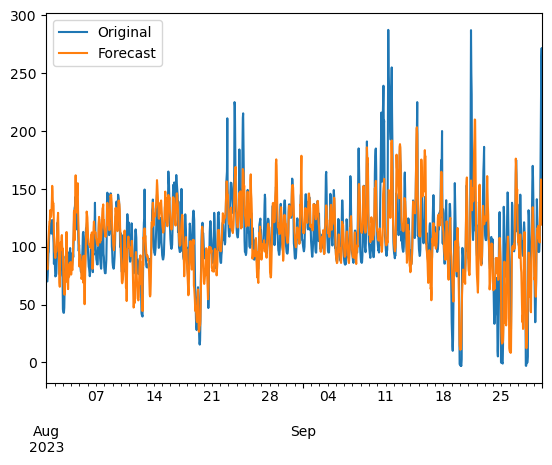

In [16]:
relu_ffnn_res.plot()
plt.show()

In [17]:
print("ReLU FFNN:")
print("RMSE:", relu_ffnn_rmse)
print("MAE:", relu_ffnn_mae)

ReLU FFNN:
RMSE: 24.031541681156845
MAE: 17.25997675151295


In [5]:
#Sigmoid Recurrent Neural Network

importlib.reload(v2tools)
importlib.reload(v2models)

model_params = {
    "init_params": {
        "num_of_blocks": 6,
        "n_timesteps": 7,
        "n_features": 7,
        "act_fn": "sigmoid",
        "n_layers": 3,
    },
    "train_params": {
        "validation_split": 0.2,
        "verbose": 1
    },
    "other_params": {
        "init_epochs": 150,
        "subseq_epochs": 35,
        "GPU": False
    }
}

sigmoid_rnn_model = v2models.rnn(model_params, None)
sigmoid_rnn_model, sigmoid_rnn_res, sigmoid_rnn_rmse, sigmoid_rnn_mae = v2tools.walk_forward_evaluation(sigmoid_rnn_model, prices, ida_prices, planned, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))

Initial setup complete.
Train Price Data Index: DatetimeIndex(['2022-09-01 01:00:00', '2022-09-01 02:00:00',
               '2022-09-01 03:00:00', '2022-09-01 04:00:00',
               '2022-09-01 05:00:00', '2022-09-01 06:00:00',
               '2022-09-01 07:00:00', '2022-09-01 08:00:00',
               '2022-09-01 09:00:00', '2022-09-01 10:00:00',
               ...
               '2023-07-31 14:00:00', '2023-07-31 15:00:00',
               '2023-07-31 16:00:00', '2023-07-31 17:00:00',
               '2023-07-31 18:00:00', '2023-07-31 19:00:00',
               '2023-07-31 20:00:00', '2023-07-31 21:00:00',
               '2023-07-31 22:00:00', '2023-07-31 23:00:00'],
              dtype='datetime64[ns]', name='DeliveryPeriod', length=8015, freq=None)
Train IDA Data Index: DatetimeIndex(['2022-09-01 01:00:00', '2022-09-01 02:00:00',
               '2022-09-01 03:00:00', '2022-09-01 04:00:00',
               '2022-09-01 05:00:00', '2022-09-01 06:00:00',
               '2022-09-01 07:00

Epoch 34/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 35/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 36/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 37/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 38/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 39/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 40/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 41/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 42/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 43/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 44/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 45/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s

KeyError: "None of [DatetimeIndex(['2023-07-31 00:00:00', '2023-07-31 01:00:00',\n               '2023-07-31 02:00:00', '2023-07-31 03:00:00',\n               '2023-07-31 04:00:00', '2023-07-31 05:00:00',\n               '2023-07-31 06:00:00', '2023-07-31 07:00:00',\n               '2023-07-31 08:00:00', '2023-07-31 09:00:00',\n               '2023-07-31 10:00:00', '2023-07-31 11:00:00',\n               '2023-07-31 12:00:00', '2023-07-31 13:00:00',\n               '2023-07-31 14:00:00', '2023-07-31 15:00:00',\n               '2023-07-31 16:00:00', '2023-07-31 17:00:00',\n               '2023-07-31 18:00:00', '2023-07-31 19:00:00',\n               '2023-07-31 20:00:00', '2023-07-31 21:00:00',\n               '2023-07-31 22:00:00', '2023-07-31 23:00:00'],\n              dtype='datetime64[ns]', name='DeliveryPeriod', freq=None)] are in the [index]"

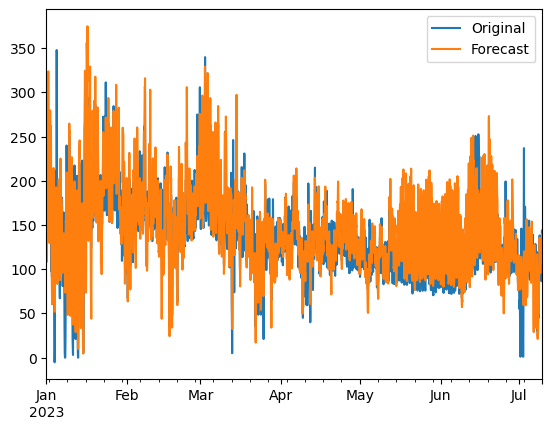

In [35]:
sigmoid_rnn_res.plot()
plt.show()

In [36]:
print("Sigmoid RNN:")
print("RMSE:", sigmoid_rnn_rmse)
print("MAE:", sigmoid_rnn_mae)

Sigmoid RNN:
RMSE: 34.196910905003385
MAE: 24.624256792545317


In [37]:
#Tanh Recurrent Neural Network

importlib.reload(v2tools)
importlib.reload(v2models)

model_params = {
    "init_params": {
        "num_of_blocks": 6,
        "n_timesteps": 7,
        "n_features": 7,
        "act_fn": "tanh",
        "n_layers": 3
    },
    "train_params": {
        "validation_split": 0.2,
        "verbose": 1
    },
    "other_params": {
        "init_epochs": 150,
        "subseq_epochs": 35,
        "GPU": False
    }
}

tanh_rnn_model = v2models.rnn(model_params, None)
tanh_rnn_model, tanh_rnn_res, tanh_rnn_rmse, tanh_rnn_mae = v2tools.walk_forward_evaluation(tanh_rnn_model, prices, ida_prices, planned, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))

Epoch 1/150
58/58 [==============================] - 6s 22ms/step - loss: 0.1701 - val_loss: 0.0982
Epoch 2/150
58/58 [==============================] - 0s 7ms/step - loss: 0.0732 - val_loss: 0.0575
Epoch 3/150
58/58 [==============================] - 0s 7ms/step - loss: 0.0397 - val_loss: 0.0591
Epoch 4/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0376 - val_loss: 0.0587
Epoch 5/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0364 - val_loss: 0.0600
Epoch 6/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 0.0579
Epoch 7/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0335 - val_loss: 0.0583
Epoch 8/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0315 - val_loss: 0.0557
Epoch 9/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0298 - val_loss: 0.0513
Epoch 10/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0272 - val_loss: 0.0535
Epoch 11

58/58 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0562
Epoch 84/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0522
Epoch 85/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0485
Epoch 86/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0542
Epoch 87/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0523
Epoch 88/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0547
Epoch 89/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0552
Epoch 90/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0555
Epoch 91/150
58/58 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0547
Epoch 92/150
58/58 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0561
Epoch 93/150


60/60 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0433
Epoch 24/35
60/60 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0442
Epoch 25/35
60/60 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0441
Epoch 26/35
60/60 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0420
Epoch 27/35
60/60 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0539
Epoch 28/35
60/60 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0413
Epoch 29/35
60/60 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0491
Epoch 30/35
60/60 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0416
Epoch 31/35
60/60 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0445
Epoch 32/35
60/60 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0466
Epoch 33/35
60/60 [===

63/63 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0418
Epoch 8/35
63/63 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0471
Epoch 9/35
63/63 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0425
Epoch 10/35
63/63 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0438
Epoch 11/35
63/63 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0460
Epoch 12/35
63/63 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0417
Epoch 13/35
63/63 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0463
Epoch 14/35
63/63 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0406
Epoch 15/35
63/63 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0445
Epoch 16/35
63/63 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0522
Epoch 17/35
63/63 [=====

65/65 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0348
Epoch 28/35
65/65 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0331
Epoch 29/35
65/65 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0349
Epoch 30/35
65/65 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0372
Epoch 31/35
65/65 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0343
Epoch 32/35
65/65 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0356
Epoch 33/35
65/65 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0348
Epoch 34/35
65/65 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0344
Epoch 35/35
1/1 [==============================] - 0s 24ms/step
Finished forecast for 2023-01-13. Forecast value: 37.67250061035156.
Epoch 1/35
66/66 [==============================] - 0s 7ms/step - loss: 0.0070 - val_lo

68/68 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0306
Epoch 12/35
68/68 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0351
Epoch 13/35
68/68 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0345
Epoch 14/35
68/68 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0333
Epoch 15/35
68/68 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0328
Epoch 16/35
68/68 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0331
Epoch 17/35
68/68 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0317
Epoch 18/35
68/68 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0326
Epoch 19/35
68/68 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0328
Epoch 20/35
68/68 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0302
Epoch 21/35
68/68 [===

71/71 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0435
Epoch 32/35
71/71 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0370
Epoch 33/35
71/71 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0392
Epoch 34/35
71/71 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0386
Epoch 35/35
1/1 [==============================] - 0s 18ms/step
Finished forecast for 2023-01-22. Forecast value: 107.02435302734375.
Epoch 1/35
71/71 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0402
Epoch 2/35
71/71 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0420
Epoch 3/35
71/71 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0359
Epoch 4/35
71/71 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0329
Epoch 5/35
71/71 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss:

74/74 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0286
Epoch 16/35
74/74 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0302
Epoch 17/35
74/74 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0331
Epoch 18/35
74/74 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0304
Epoch 19/35
74/74 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0320
Epoch 20/35
74/74 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0313
Epoch 21/35
74/74 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0324
Epoch 22/35
74/74 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0326
Epoch 23/35
74/74 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0340
Epoch 24/35
74/74 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0360
Epoch 25/35
74/74 [===

1/1 [==============================] - 0s 16ms/step
Finished forecast for 2023-01-31. Forecast value: 89.73650360107422.
Epoch 1/35
77/77 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0344
Epoch 2/35
77/77 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0343
Epoch 3/35
77/77 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0346
Epoch 4/35
77/77 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0330
Epoch 5/35
77/77 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0379
Epoch 6/35
77/77 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0339
Epoch 7/35
77/77 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0337
Epoch 8/35
77/77 [==============================] - 1s 8ms/step - loss: 0.0049 - val_loss: 0.0337
Epoch 9/35
77/77 [==============================] - 1s 8ms/step - loss: 0.0049 - val_loss: 0.03

79/79 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0247
Epoch 20/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0277
Epoch 21/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0266
Epoch 22/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0251
Epoch 23/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0274
Epoch 24/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0232
Epoch 25/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0231
Epoch 26/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0255
Epoch 27/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0247
Epoch 28/35
79/79 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0251
Epoch 29/35
79/79 [===

82/82 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0204
Epoch 4/35
82/82 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0241
Epoch 5/35
82/82 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0222
Epoch 6/35
82/82 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0244
Epoch 7/35
82/82 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0246
Epoch 8/35
82/82 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0247
Epoch 9/35
82/82 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0261
Epoch 10/35
82/82 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0229
Epoch 11/35
82/82 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0257
Epoch 12/35
82/82 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0239
Epoch 13/35
82/82 [=========

85/85 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0209
Epoch 24/35
85/85 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0217
Epoch 25/35
85/85 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0213
Epoch 26/35
85/85 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0202
Epoch 27/35
85/85 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0222
Epoch 28/35
85/85 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0209
Epoch 29/35
85/85 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0189
Epoch 30/35
85/85 [==============================] - 1s 7ms/step - loss: 0.0038 - val_loss: 0.0209
Epoch 31/35
85/85 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0211
Epoch 32/35
85/85 [==============================] - 1s 7ms/step - loss: 0.0038 - val_loss: 0.0176
Epoch 33/35
85/85 [===

88/88 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0117
Epoch 8/35
88/88 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0149
Epoch 9/35
88/88 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0126
Epoch 10/35
88/88 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0124
Epoch 11/35
88/88 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0124
Epoch 12/35
88/88 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0135
Epoch 13/35
88/88 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0144
Epoch 14/35
88/88 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0121
Epoch 15/35
88/88 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0129
Epoch 16/35
88/88 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0132
Epoch 17/35
88/88 [=====

90/90 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0112
Epoch 28/35
90/90 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0108
Epoch 29/35
90/90 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0101
Epoch 30/35
90/90 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0107
Epoch 31/35
90/90 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0108
Epoch 32/35
90/90 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0117
Epoch 33/35
90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0106
Epoch 34/35
90/90 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0100
Epoch 35/35
1/1 [==============================] - 0s 21ms/step
Finished forecast for 2023-02-23. Forecast value: 120.65646362304688.
Epoch 1/35
91/91 [==============================] - 1s 6ms/step - loss: 0.0031 - val_l

93/93 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0112
Epoch 12/35
93/93 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0107
Epoch 13/35
93/93 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0099
Epoch 14/35
93/93 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0101
Epoch 15/35
93/93 [==============================] - 1s 7ms/step - loss: 0.0029 - val_loss: 0.0098
Epoch 16/35
93/93 [==============================] - 1s 7ms/step - loss: 0.0029 - val_loss: 0.0094
Epoch 17/35
93/93 [==============================] - 1s 7ms/step - loss: 0.0029 - val_loss: 0.0099
Epoch 18/35
93/93 [==============================] - 1s 7ms/step - loss: 0.0029 - val_loss: 0.0107
Epoch 19/35
93/93 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0106
Epoch 20/35
93/93 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0102
Epoch 21/35
93/93 [===

95/95 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0096
Epoch 32/35
95/95 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0099
Epoch 33/35
95/95 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0097
Epoch 34/35
95/95 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0109
Epoch 35/35
1/1 [==============================] - 0s 18ms/step
Finished forecast for 2023-03-04. Forecast value: 174.595458984375.
Epoch 1/35
96/96 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0098
Epoch 2/35
96/96 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0105
Epoch 3/35
96/96 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0109
Epoch 4/35
96/96 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0096
Epoch 5/35
96/96 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 0

98/98 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 16/35
98/98 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0103
Epoch 17/35
98/98 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0101
Epoch 18/35
98/98 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0099
Epoch 19/35
98/98 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0096
Epoch 20/35
98/98 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0108
Epoch 21/35
98/98 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0100
Epoch 22/35
98/98 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0105
Epoch 23/35
98/98 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0099
Epoch 24/35
98/98 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0096
Epoch 25/35
98/98 [===

100/100 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0105
Epoch 26/35
100/100 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 27/35
100/100 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 28/35
100/100 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0107
Epoch 29/35
100/100 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0105
Epoch 30/35
100/100 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0104
Epoch 31/35
100/100 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 32/35
100/100 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0102
Epoch 33/35
100/100 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0104
Epoch 34/35
100/100 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0105
Ep

Epoch 34/35
101/101 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0100
Epoch 35/35
1/1 [==============================] - 0s 20ms/step
Finished forecast for 2023-03-13. Forecast value: 95.46993255615234.
Epoch 1/35
101/101 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0108
Epoch 2/35
101/101 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0103
Epoch 3/35
101/101 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0097
Epoch 4/35
101/101 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0101
Epoch 5/35
101/101 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0107
Epoch 6/35
101/101 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0103
Epoch 7/35
101/101 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0102
Epoch 8/35
101/101 [==============================] - 1s 6ms/step 

104/104 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0098
Epoch 16/35
104/104 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0099
Epoch 17/35
104/104 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 18/35
104/104 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0103
Epoch 19/35
104/104 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 20/35
104/104 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 21/35
104/104 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0097
Epoch 22/35
104/104 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 23/35
104/104 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0098
Epoch 24/35
104/104 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0100
Ep

Epoch 24/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0103
Epoch 25/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0106
Epoch 26/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0104
Epoch 27/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0103
Epoch 28/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 29/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0105
Epoch 30/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 31/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 32/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0101
Epoch 33/35
105/105 [==============================] - 1s 6ms/step - loss: 0.0025 - val_los

Epoch 33/35
106/106 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0098
Epoch 34/35
106/106 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0100
Epoch 35/35
1/1 [==============================] - 0s 16ms/step
Finished forecast for 2023-03-22. Forecast value: 99.73786163330078.
Epoch 1/35
107/107 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0100
Epoch 2/35
107/107 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0103
Epoch 3/35
107/107 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0102
Epoch 4/35
107/107 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0099
Epoch 5/35
107/107 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 6/35
107/107 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0097
Epoch 7/35
107/107 [==============================] - 1s 7ms/step

109/109 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0105
Epoch 15/35
109/109 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0101
Epoch 16/35
109/109 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0099
Epoch 17/35
109/109 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0101
Epoch 18/35
109/109 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0104
Epoch 19/35
109/109 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0095
Epoch 20/35
109/109 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0101
Epoch 21/35
109/109 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0099
Epoch 22/35
109/109 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0097
Epoch 23/35
109/109 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0099
Ep

110/110 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0106
Epoch 24/35
110/110 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0098
Epoch 25/35
110/110 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0102
Epoch 26/35
110/110 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0101
Epoch 27/35
110/110 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0102
Epoch 28/35
110/110 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0098
Epoch 29/35
110/110 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0100
Epoch 30/35
110/110 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0101
Epoch 31/35
110/110 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 32/35
110/110 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0103
Ep

Epoch 32/35
112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0104
Epoch 33/35
112/112 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0106
Epoch 34/35
112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0099
Epoch 35/35
1/1 [==============================] - 0s 16ms/step
Finished forecast for 2023-03-31. Forecast value: 163.42242431640625.
Epoch 1/35
112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0099
Epoch 2/35
112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0098
Epoch 3/35
112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0104
Epoch 4/35
112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 5/35
112/112 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0102
Epoch 6/35
112/112 [==============================] - 1s 6ms/st

115/115 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0097
Epoch 14/35
115/115 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0099
Epoch 15/35
115/115 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0093
Epoch 16/35
115/115 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 17/35
115/115 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0099
Epoch 18/35
115/115 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 19/35
115/115 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0099
Epoch 20/35
115/115 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0098
Epoch 21/35
115/115 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0104
Epoch 22/35
115/115 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0097
Ep

116/116 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0094
Epoch 23/35
116/116 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0099
Epoch 24/35
116/116 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0091
Epoch 25/35
116/116 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0089
Epoch 26/35
116/116 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 27/35
116/116 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0093
Epoch 28/35
116/116 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 29/35
116/116 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch 30/35
116/116 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0091
Epoch 31/35
116/116 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0091
Ep

Epoch 31/35
117/117 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0095
Epoch 32/35
117/117 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0090
Epoch 33/35
117/117 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0096
Epoch 34/35
117/117 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0096
Epoch 35/35
1/1 [==============================] - 0s 18ms/step
Finished forecast for 2023-04-09. Forecast value: 120.73213195800781.
Epoch 1/35
118/118 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0097
Epoch 2/35
118/118 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0092
Epoch 3/35
118/118 [==============================] - 1s 7ms/step - loss: 0.0025 - val_loss: 0.0095
Epoch 4/35
118/118 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0100
Epoch 5/35
118/118 [==============================] - 1s 7ms/s

120/120 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0090
Epoch 13/35
120/120 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0089
Epoch 14/35
120/120 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 15/35
120/120 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0085
Epoch 16/35
120/120 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 17/35
120/120 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0092
Epoch 18/35
120/120 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 19/35
120/120 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0087
Epoch 20/35
120/120 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0087
Epoch 21/35
120/120 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0088
Ep

Epoch 21/35
121/121 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 22/35
121/121 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0089
Epoch 23/35
121/121 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0093
Epoch 24/35
121/121 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0090
Epoch 25/35
121/121 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0085
Epoch 26/35
121/121 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0095
Epoch 27/35
121/121 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 28/35
121/121 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0090
Epoch 29/35
121/121 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch 30/35
121/121 [==============================] - 1s 6ms/step - loss: 0.0022 - val_los

Epoch 30/35
122/122 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0089
Epoch 31/35
122/122 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0089
Epoch 32/35
122/122 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0094
Epoch 33/35
122/122 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0090
Epoch 34/35
122/122 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 35/35
1/1 [==============================] - 0s 15ms/step
Finished forecast for 2023-04-18. Forecast value: 135.82638549804688.
Epoch 1/35
123/123 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 2/35
123/123 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0094
Epoch 3/35
123/123 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0094
Epoch 4/35
123/123 [==============================] - 1s 6ms/

125/125 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0109
Epoch 12/35
125/125 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0103
Epoch 13/35
125/125 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0107
Epoch 14/35
125/125 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0114
Epoch 15/35
125/125 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0118
Epoch 16/35
125/125 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0112
Epoch 17/35
125/125 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 18/35
125/125 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0112
Epoch 19/35
125/125 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0114
Epoch 20/35
125/125 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0109
Ep

127/127 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0109
Epoch 21/35
127/127 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 22/35
127/127 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0108
Epoch 23/35
127/127 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 24/35
127/127 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 25/35
127/127 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0109
Epoch 26/35
127/127 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 27/35
127/127 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0114
Epoch 28/35
127/127 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0115
Epoch 29/35
127/127 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0100
Ep

128/128 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0112
Epoch 30/35
128/128 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0113
Epoch 31/35
128/128 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0108
Epoch 32/35
128/128 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0107
Epoch 33/35
128/128 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0108
Epoch 34/35
128/128 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0103
Epoch 35/35
1/1 [==============================] - 0s 16ms/step
Finished forecast for 2023-04-27. Forecast value: 132.04209899902344.
Epoch 1/35
128/128 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0111
Epoch 2/35
128/128 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0107
Epoch 3/35
128/128 [==============================] - 1s 6ms/step - loss

Epoch 2/35
130/130 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0112
Epoch 3/35
130/130 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0105
Epoch 4/35
130/130 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0106
Epoch 5/35
130/130 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0113
Epoch 6/35
130/130 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0114
Epoch 7/35
130/130 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0107
Epoch 8/35
130/130 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0109
Epoch 9/35
130/130 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0104
Epoch 10/35
130/130 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0118
Epoch 11/35
130/130 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.011

Epoch 11/35
131/131 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 12/35
131/131 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0110
Epoch 13/35
131/131 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 14/35
131/131 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0106
Epoch 15/35
131/131 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 16/35
131/131 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0102
Epoch 17/35
131/131 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0104
Epoch 18/35
131/131 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 19/35
131/131 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0105
Epoch 20/35
131/131 [==============================] - 1s 7ms/step - loss: 0.0022 - val_los

Epoch 20/35
132/132 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0105
Epoch 21/35
132/132 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0101
Epoch 22/35
132/132 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0104
Epoch 23/35
132/132 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0099
Epoch 24/35
132/132 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0098
Epoch 25/35
132/132 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0103
Epoch 26/35
132/132 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0096
Epoch 27/35
132/132 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0097
Epoch 28/35
132/132 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0105
Epoch 29/35
132/132 [==============================] - 1s 6ms/step - loss: 0.0021 - val_los

Epoch 29/35
133/133 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 30/35
133/133 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0071
Epoch 31/35
133/133 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0072
Epoch 32/35
133/133 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0074
Epoch 33/35
133/133 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 34/35
133/133 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 35/35
1/1 [==============================] - 0s 19ms/step
Finished forecast for 2023-05-06. Forecast value: 159.0263214111328.
Epoch 1/35
134/134 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0083
Epoch 2/35
134/134 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 3/35
134/134 [==============================] - 1s 6ms/

136/136 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 11/35
136/136 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 12/35
136/136 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0071
Epoch 13/35
136/136 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 14/35
136/136 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0075
Epoch 15/35
136/136 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0081
Epoch 16/35
136/136 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 17/35
136/136 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0075
Epoch 18/35
136/136 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0079
Epoch 19/35
136/136 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0067
Ep

137/137 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0082
Epoch 20/35
137/137 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 21/35
137/137 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0081
Epoch 22/35
137/137 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0078
Epoch 23/35
137/137 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 24/35
137/137 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 25/35
137/137 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0067
Epoch 26/35
137/137 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0076
Epoch 27/35
137/137 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0075
Epoch 28/35
137/137 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0074
Ep

Epoch 28/35
139/139 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 29/35
139/139 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0076
Epoch 30/35
139/139 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0071
Epoch 31/35
139/139 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0093
Epoch 32/35
139/139 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0080
Epoch 33/35
139/139 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 34/35
139/139 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0076
Epoch 35/35
1/1 [==============================] - 0s 20ms/step
Finished forecast for 2023-05-15. Forecast value: 112.88520812988281.
Epoch 1/35
139/139 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0071
Epoch 2/35
139/139 [==============================] - 1s 6m

Epoch 1/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 2/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0066
Epoch 3/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch 4/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0065
Epoch 5/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0065
Epoch 6/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 7/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 8/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 9/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0059
Epoch 10/35
140/140 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0066

Epoch 10/35
142/142 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0077
Epoch 11/35
142/142 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0078
Epoch 12/35
142/142 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 13/35
142/142 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0077
Epoch 14/35
142/142 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0080
Epoch 15/35
142/142 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0076
Epoch 16/35
142/142 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0083
Epoch 17/35
142/142 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0091
Epoch 18/35
142/142 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0080
Epoch 19/35
142/142 [==============================] - 1s 7ms/step - loss: 0.0022 - val_los

Epoch 19/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0080
Epoch 20/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0095
Epoch 21/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0097
Epoch 22/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0104
Epoch 23/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 24/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0103
Epoch 25/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 26/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 27/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0097
Epoch 28/35
143/143 [==============================] - 1s 6ms/step - loss: 0.0022 - val_los

Epoch 28/35
144/144 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0098
Epoch 29/35
144/144 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0092
Epoch 30/35
144/144 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0107
Epoch 31/35
144/144 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0106
Epoch 32/35
144/144 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0087
Epoch 33/35
144/144 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0111
Epoch 34/35
144/144 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0090
Epoch 35/35
1/1 [==============================] - 0s 10ms/step
Finished forecast for 2023-05-24. Forecast value: 104.47695922851562.
Epoch 1/35
145/145 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0108
Epoch 2/35
145/145 [==============================] - 1s 6m

Epoch 1/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0122
Epoch 2/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0141
Epoch 3/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0124
Epoch 4/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0127
Epoch 5/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0124
Epoch 6/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0130
Epoch 7/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 8/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0116
Epoch 9/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0142
Epoch 10/35
146/146 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0111

Epoch 10/35
147/147 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0137
Epoch 11/35
147/147 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0119
Epoch 12/35
147/147 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0126
Epoch 13/35
147/147 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0123
Epoch 14/35
147/147 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0133
Epoch 15/35
147/147 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0131
Epoch 16/35
147/147 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0113
Epoch 17/35
147/147 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0109
Epoch 18/35
147/147 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0149
Epoch 19/35
147/147 [==============================] - 1s 6ms/step - loss: 0.0022 - val_los

Epoch 19/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0153
Epoch 20/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0137
Epoch 21/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0136
Epoch 22/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0139
Epoch 23/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0125
Epoch 24/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0127
Epoch 25/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0128
Epoch 26/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0122
Epoch 27/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0145
Epoch 28/35
148/148 [==============================] - 1s 6ms/step - loss: 0.0021 - val_los

Epoch 28/35
149/149 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0148
Epoch 29/35
149/149 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0169
Epoch 30/35
149/149 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0166
Epoch 31/35
149/149 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0162
Epoch 32/35
149/149 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0162
Epoch 33/35
149/149 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0150
Epoch 34/35
149/149 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0148
Epoch 35/35
1/1 [==============================] - 0s 15ms/step
Finished forecast for 2023-06-02. Forecast value: 122.18106079101562.
Epoch 1/35
150/150 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0150
Epoch 2/35
150/150 [==============================] - 1s 6m

Epoch 1/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0208
Epoch 2/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0164
Epoch 3/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0160
Epoch 4/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0157
Epoch 5/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0177
Epoch 6/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0146
Epoch 7/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0148
Epoch 8/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0196
Epoch 9/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0155
Epoch 10/35
151/151 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0199

152/152 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0163
Epoch 11/35
152/152 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0148
Epoch 12/35
152/152 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0187
Epoch 13/35
152/152 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0164
Epoch 14/35
152/152 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0159
Epoch 15/35
152/152 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0170
Epoch 16/35
152/152 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0154
Epoch 17/35
152/152 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0156
Epoch 18/35
152/152 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0150
Epoch 19/35
152/152 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0143
Ep

Epoch 19/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0161
Epoch 20/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0141
Epoch 21/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0185
Epoch 22/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0157
Epoch 23/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0159
Epoch 24/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0143
Epoch 25/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0158
Epoch 26/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0191
Epoch 27/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0123
Epoch 28/35
154/154 [==============================] - 1s 6ms/step - loss: 0.0021 - val_los

Epoch 28/35
155/155 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0152
Epoch 29/35
155/155 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0163
Epoch 30/35
155/155 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0159
Epoch 31/35
155/155 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0165
Epoch 32/35
155/155 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0162
Epoch 33/35
155/155 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0141
Epoch 34/35
155/155 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0163
Epoch 35/35
1/1 [==============================] - 0s 15ms/step
Finished forecast for 2023-06-11. Forecast value: 93.55294036865234.
Epoch 1/35
155/155 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0156
Epoch 2/35
155/155 [==============================] - 1s 6ms

157/157 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0150
Epoch 2/35
157/157 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0154
Epoch 3/35
157/157 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0184
Epoch 4/35
157/157 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0160
Epoch 5/35
157/157 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0142
Epoch 6/35
157/157 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0193
Epoch 7/35
157/157 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0157
Epoch 8/35
157/157 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0164
Epoch 9/35
157/157 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0130
Epoch 10/35
157/157 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0126
Epoch 11/3

158/158 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0147
Epoch 11/35
158/158 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0133
Epoch 12/35
158/158 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0139
Epoch 13/35
158/158 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0143
Epoch 14/35
158/158 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0153
Epoch 15/35
158/158 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0138
Epoch 16/35
158/158 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0133
Epoch 17/35
158/158 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0140
Epoch 18/35
158/158 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0152
Epoch 19/35
158/158 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0140
Ep

159/159 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0136
Epoch 20/35
159/159 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0143
Epoch 21/35
159/159 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0145
Epoch 22/35
159/159 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0138
Epoch 23/35
159/159 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0134
Epoch 24/35
159/159 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0136
Epoch 25/35
159/159 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0127
Epoch 26/35
159/159 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0116
Epoch 27/35
159/159 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0148
Epoch 28/35
159/159 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0132
Ep

160/160 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0145
Epoch 29/35
160/160 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0127
Epoch 30/35
160/160 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0124
Epoch 31/35
160/160 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0156
Epoch 32/35
160/160 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0135
Epoch 33/35
160/160 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0146
Epoch 34/35
160/160 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0124
Epoch 35/35
1/1 [==============================] - 0s 11ms/step
Finished forecast for 2023-06-20. Forecast value: 114.04366302490234.
Epoch 1/35
161/161 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0132
Epoch 2/35
161/161 [==============================] - 1s 6ms/step - los

Epoch 1/35
162/162 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0131
Epoch 2/35
162/162 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0132
Epoch 3/35
162/162 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0127
Epoch 4/35
162/162 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0130
Epoch 5/35
162/162 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0136
Epoch 6/35
162/162 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0144
Epoch 7/35
162/162 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0130
Epoch 8/35
162/162 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0139
Epoch 9/35
162/162 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0130
Epoch 10/35
162/162 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0132

Epoch 10/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0132
Epoch 11/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0133
Epoch 12/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0128
Epoch 13/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0125
Epoch 14/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0130
Epoch 15/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0125
Epoch 16/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0123
Epoch 17/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0130
Epoch 18/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0129
Epoch 19/35
163/163 [==============================] - 1s 6ms/step - loss: 0.0020 - val_los

Epoch 19/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0125
Epoch 20/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0138
Epoch 21/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0136
Epoch 22/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0130
Epoch 23/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0135
Epoch 24/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0123
Epoch 25/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0127
Epoch 26/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0133
Epoch 27/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0122
Epoch 28/35
164/164 [==============================] - 1s 6ms/step - loss: 0.0019 - val_los

Epoch 28/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0133
Epoch 29/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0145
Epoch 30/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0144
Epoch 31/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0136
Epoch 32/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0143
Epoch 33/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0138
Epoch 34/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0154
Epoch 35/35
1/1 [==============================] - 0s 17ms/step
Finished forecast for 2023-06-29. Forecast value: 126.10172271728516.
Epoch 1/35
166/166 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0134
Epoch 2/35
166/166 [==============================] - 1s 6m

167/167 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0183
Epoch 2/35
167/167 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0180
Epoch 3/35
167/167 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0163
Epoch 4/35
167/167 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0181
Epoch 5/35
167/167 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0169
Epoch 6/35
167/167 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0170
Epoch 7/35
167/167 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0173
Epoch 8/35
167/167 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0171
Epoch 9/35
167/167 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0166
Epoch 10/35
167/167 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0171
Epoch 11/3

169/169 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0155
Epoch 11/35
169/169 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0167
Epoch 12/35
169/169 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0163
Epoch 13/35
169/169 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0173
Epoch 14/35
169/169 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0163
Epoch 15/35
169/169 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0159
Epoch 16/35
169/169 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0153
Epoch 17/35
169/169 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0158
Epoch 18/35
169/169 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0156
Epoch 19/35
169/169 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0175
Ep

Epoch 19/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0150
Epoch 20/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0143
Epoch 21/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0147
Epoch 22/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0152
Epoch 23/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0151
Epoch 24/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0146
Epoch 25/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0143
Epoch 26/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0147
Epoch 27/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0146
Epoch 28/35
170/170 [==============================] - 1s 6ms/step - loss: 0.0019 - val_los

Epoch 28/35
171/171 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0126
Epoch 29/35
171/171 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0122
Epoch 30/35
171/171 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0122
Epoch 31/35
171/171 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0111
Epoch 32/35
171/171 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0119
Epoch 33/35
171/171 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0129
Epoch 34/35
171/171 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0120
Epoch 35/35
1/1 [==============================] - 0s 11ms/step
Finished forecast for 2023-07-08. Forecast value: 82.09609985351562.
Epoch 1/35
172/172 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0120
Epoch 2/35
172/172 [==============================] - 1s 6ms

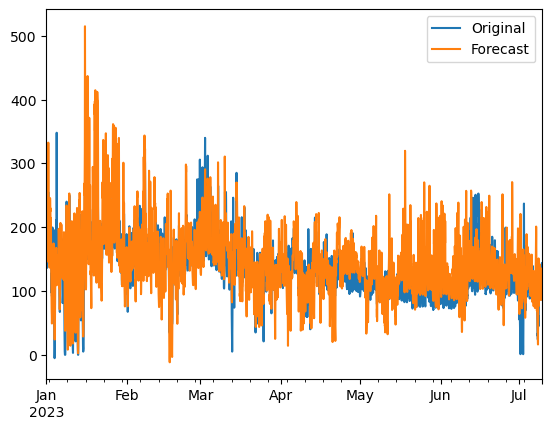

In [38]:
tanh_rnn_res.plot()
plt.show()

In [39]:
print("Tanh RNN:")
print("RMSE:", tanh_rnn_rmse)
print("MAE:", tanh_rnn_mae)

Tanh RNN:
RMSE: 43.01790925341201
MAE: 30.491417548422223


In [40]:
#ReLU Recurrent Neural Network

importlib.reload(v2tools)
importlib.reload(v2models)

model_params = {
    "init_params": {
        "num_of_blocks": 6,
        "n_timesteps": 7,
        "n_features": 7,
        "act_fn": "relu",
        "n_layers": 3,
    },
    "train_params": {
        "validation_split": 0,
        "verbose": 0
    },
    "other_params": {
        "init_epochs": 150,
        "subseq_epochs": 35,
        "GPU": False
    }
}

relu_rnn_model = v2models.rnn(model_params, None)
relu_rnn_model, relu_rnn_res, relu_rnn_rmse, relu_rnn_mae = v2tools.walk_forward_evaluation(relu_rnn_model, prices, ida_prices, planned, start=dt.datetime(2023,8,1), end=dt.datetime(2023,9,29))

1/1 [==============================] - 0s 293ms/step
Finished forecast for 2023-01-01. Forecast value: 154.87196350097656.
1/1 [==============================] - 0s 14ms/step
Finished forecast for 2023-01-02. Forecast value: 177.31234741210938.
1/1 [==============================] - 0s 16ms/step
Finished forecast for 2023-01-03. Forecast value: 44.13508987426758.
1/1 [==============================] - 0s 21ms/step
Finished forecast for 2023-01-04. Forecast value: 97.38573455810547.
1/1 [==============================] - 0s 16ms/step
Finished forecast for 2023-01-05. Forecast value: 170.5850067138672.
1/1 [==============================] - 0s 18ms/step
Finished forecast for 2023-01-06. Forecast value: 115.75818634033203.
1/1 [==============================] - 0s 16ms/step
Finished forecast for 2023-01-07. Forecast value: 132.9261932373047.
1/1 [==============================] - 0s 18ms/step
Finished forecast for 2023-01-08. Forecast value: 100.0302505493164.
1/1 [=======================

1/1 [==============================] - 0s 19ms/step
Finished forecast for 2023-03-10. Forecast value: 105.38447570800781.
1/1 [==============================] - 0s 17ms/step
Finished forecast for 2023-03-11. Forecast value: 148.13624572753906.
1/1 [==============================] - 0s 17ms/step
Finished forecast for 2023-03-12. Forecast value: 120.74107360839844.
1/1 [==============================] - 0s 21ms/step
Finished forecast for 2023-03-13. Forecast value: 120.52371978759766.
1/1 [==============================] - 0s 11ms/step
Finished forecast for 2023-03-14. Forecast value: 159.42144775390625.
1/1 [==============================] - 0s 19ms/step
Finished forecast for 2023-03-15. Forecast value: 197.87933349609375.
1/1 [==============================] - 0s 20ms/step
Finished forecast for 2023-03-16. Forecast value: 142.329833984375.
1/1 [==============================] - 0s 17ms/step
Finished forecast for 2023-03-17. Forecast value: 119.22681427001953.
1/1 [=====================

1/1 [==============================] - 0s 14ms/step
Finished forecast for 2023-05-17. Forecast value: 100.45291137695312.
1/1 [==============================] - 0s 18ms/step
Finished forecast for 2023-05-18. Forecast value: 81.6821060180664.
1/1 [==============================] - 0s 16ms/step
Finished forecast for 2023-05-19. Forecast value: 77.412841796875.
1/1 [==============================] - 0s 13ms/step
Finished forecast for 2023-05-20. Forecast value: 85.21135711669922.
1/1 [==============================] - 0s 20ms/step
Finished forecast for 2023-05-21. Forecast value: 53.45355224609375.
1/1 [==============================] - 0s 13ms/step
Finished forecast for 2023-05-22. Forecast value: 46.36567687988281.
1/1 [==============================] - 0s 19ms/step
Finished forecast for 2023-05-23. Forecast value: 75.77433776855469.
1/1 [==============================] - 0s 14ms/step
Finished forecast for 2023-05-24. Forecast value: 81.68970489501953.
1/1 [=============================

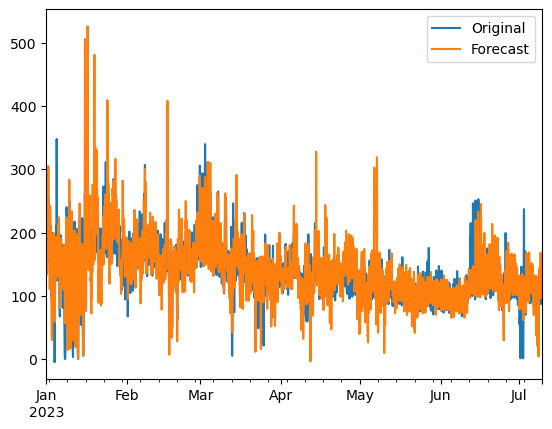

In [41]:
relu_rnn_res.plot()
plt.show()

In [42]:
print("ReLU RNN:")
print("RMSE:", relu_rnn_rmse)
print("MAE:", relu_rnn_mae)

ReLU RNN:
RMSE: 29.767028711551813
MAE: 20.563536573702564


In [65]:
res_naive1d.to_csv("Results/v2naive_1d_forecasts.csv") 
res_naive7d.to_csv("Results/naive_7d_forecasts.csv") 
res_naive1y.to_csv("Results/naive_1y_forecasts.csv")
rf_res.to_csv("Results/v2rf_forecasts.csv") 
rf_model.variable_importances.to_csv("Results/v2rf_vi.csv")
ar_res.to_csv("Results/v2ar_forecasts.csv")
arx_res.to_csv("Results/v2arx_forecasts.csv")
sigmoid_ffnn_res.to_csv("Results/v2sigmoid_ffnn_forecasts.csv")
tanh_ffnn_res.to_csv("Results/v2tanh_ffnn_forecasts.csv")
relu_ffnn_res.to_csv("Results/v2relu_ffnn_forecasts.csv")
sigmoid_rnn_res.to_csv("Results/v2sigmoid_rnn_forecasts.csv")
tanh_rnn_res.to_csv("Results/v2tanh_rnn_forecasts.csv")
relu_rnn_res.to_csv("Results/v2relu_rnn_forecasts.csv")


,RMSE
random_forest,23.46
ARX,25.74
FFNN_relu,27.93
AR,28.98
RNN_relu,29.77
naive_1d,32.34
FFNN_tanh,33.83
RNN_sigmoid,34.20
RNN_tanh,43.02
FFNN_sigmoid,44.68


,MAE
random_forest,16.79
ARX,19.53
AR,19.69
RNN_relu,20.56
FFNN_relu,20.79
naive_1d,21.43
RNN_sigmoid,24.62
FFNN_tanh,26.38
RNN_tanh,30.49
FFNN_sigmoid,36.92


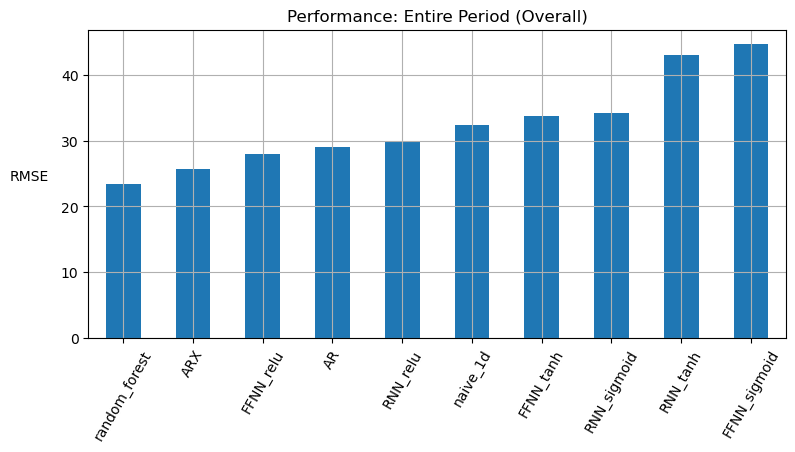

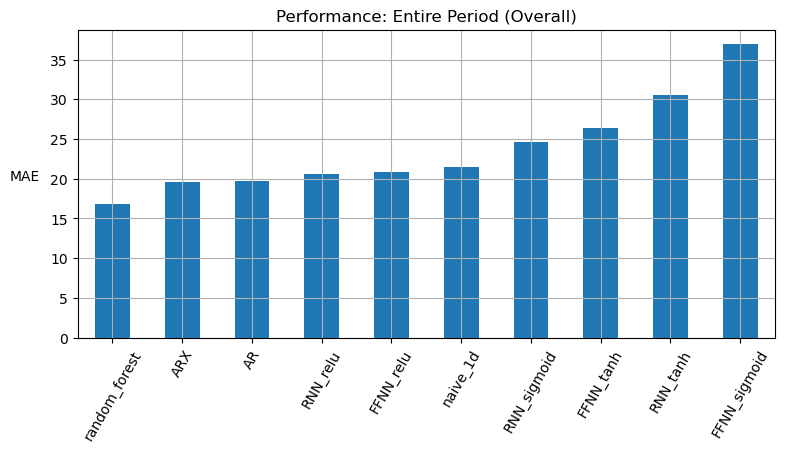

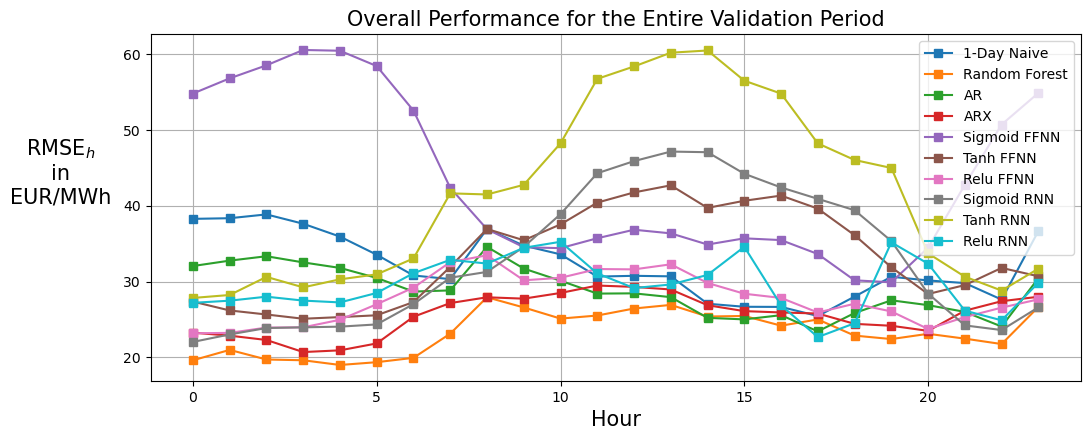

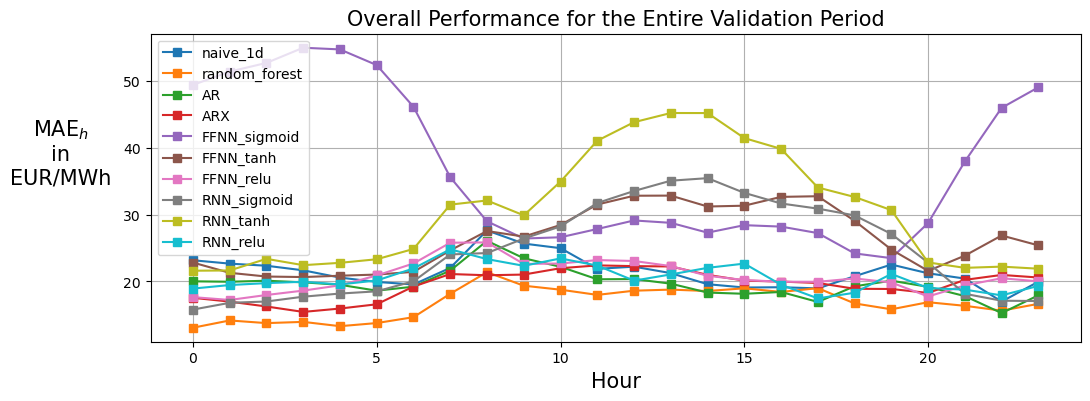

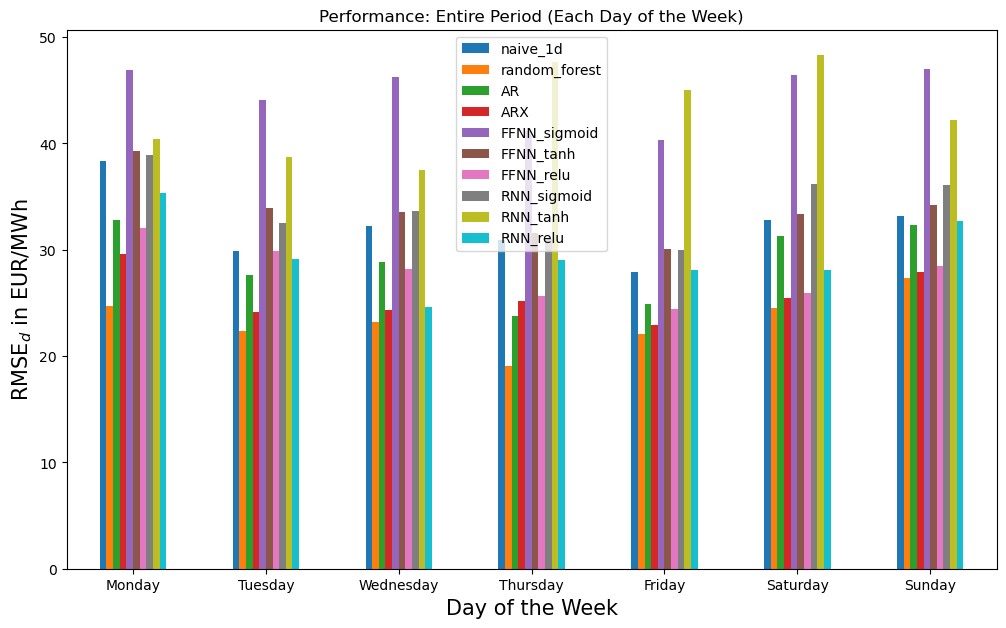

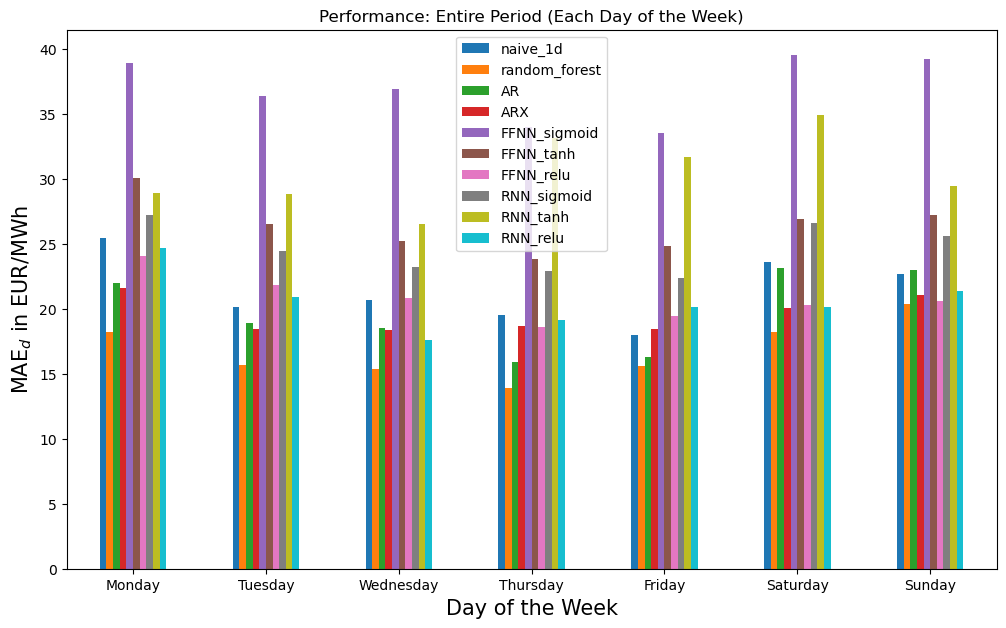

Available columns in the CSV file: ['auction', 'DeliveryPeriod', 'EURPrices', 'price_gbp', 'ni_vols', 'ni_netpos', 'roi_vols', 'roi_netpos', 'DeliveryDate', 'DeliveryHour', 'DeliveryInterval', 'semo_vols', 'doy', 'dow', 'week', 'dom', 'Month', 'year']


0.06160684612828182

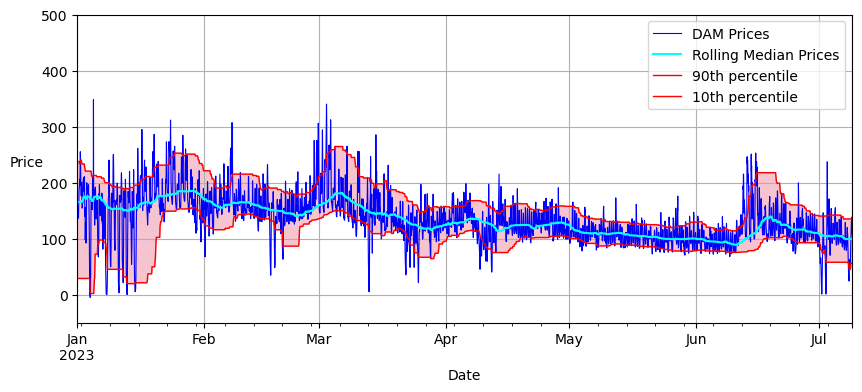

KeyError: "[Timestamp('2023-07-10 17:00:00'), Timestamp('2023-07-10 18:00:00'), Timestamp('2023-07-10 19:00:00'), Timestamp('2023-07-10 20:00:00'), Timestamp('2023-07-10 21:00:00'), Timestamp('2023-07-11 07:00:00'), Timestamp('2023-07-11 08:00:00'), Timestamp('2023-07-12 14:00:00'), Timestamp('2023-07-13 18:00:00'), Timestamp('2023-07-13 19:00:00'), Timestamp('2023-07-13 20:00:00'), Timestamp('2023-07-14 15:00:00'), Timestamp('2023-07-14 16:00:00'), Timestamp('2023-07-15 01:00:00'), Timestamp('2023-07-15 02:00:00'), Timestamp('2023-07-15 03:00:00'), Timestamp('2023-07-15 04:00:00'), Timestamp('2023-07-15 05:00:00'), Timestamp('2023-07-15 06:00:00'), Timestamp('2023-07-15 07:00:00'), Timestamp('2023-07-15 11:00:00'), Timestamp('2023-07-15 12:00:00'), Timestamp('2023-07-15 13:00:00'), Timestamp('2023-07-15 14:00:00'), Timestamp('2023-07-15 15:00:00'), Timestamp('2023-07-15 16:00:00'), Timestamp('2023-07-15 17:00:00'), Timestamp('2023-07-15 18:00:00'), Timestamp('2023-07-15 19:00:00'), Timestamp('2023-07-15 20:00:00'), Timestamp('2023-07-15 21:00:00'), Timestamp('2023-07-15 22:00:00'), Timestamp('2023-07-15 23:00:00'), Timestamp('2023-07-16 00:00:00'), Timestamp('2023-07-16 01:00:00'), Timestamp('2023-07-16 02:00:00'), Timestamp('2023-07-16 03:00:00'), Timestamp('2023-07-16 04:00:00'), Timestamp('2023-07-16 05:00:00'), Timestamp('2023-07-16 06:00:00'), Timestamp('2023-07-16 07:00:00'), Timestamp('2023-07-16 08:00:00'), Timestamp('2023-07-16 22:00:00'), Timestamp('2023-07-17 18:00:00'), Timestamp('2023-07-17 20:00:00'), Timestamp('2023-07-18 18:00:00'), Timestamp('2023-07-19 19:00:00'), Timestamp('2023-07-19 20:00:00'), Timestamp('2023-07-19 21:00:00'), Timestamp('2023-07-20 18:00:00'), Timestamp('2023-07-20 19:00:00'), Timestamp('2023-07-20 20:00:00'), Timestamp('2023-07-21 08:00:00'), Timestamp('2023-07-23 02:00:00'), Timestamp('2023-07-23 03:00:00'), Timestamp('2023-07-23 04:00:00'), Timestamp('2023-07-23 05:00:00'), Timestamp('2023-07-23 06:00:00'), Timestamp('2023-07-23 07:00:00'), Timestamp('2023-07-23 08:00:00'), Timestamp('2023-07-24 08:00:00'), Timestamp('2023-07-24 19:00:00'), Timestamp('2023-07-24 20:00:00'), Timestamp('2023-07-24 21:00:00'), Timestamp('2023-07-24 23:00:00'), Timestamp('2023-07-25 07:00:00'), Timestamp('2023-07-25 08:00:00'), Timestamp('2023-07-25 09:00:00'), Timestamp('2023-07-25 10:00:00'), Timestamp('2023-07-25 11:00:00'), Timestamp('2023-07-25 12:00:00'), Timestamp('2023-07-25 13:00:00'), Timestamp('2023-07-25 14:00:00'), Timestamp('2023-07-25 15:00:00'), Timestamp('2023-07-25 16:00:00'), Timestamp('2023-07-25 17:00:00'), Timestamp('2023-07-25 18:00:00'), Timestamp('2023-07-25 19:00:00'), Timestamp('2023-07-25 20:00:00'), Timestamp('2023-07-25 21:00:00'), Timestamp('2023-07-25 22:00:00'), Timestamp('2023-07-27 17:00:00'), Timestamp('2023-07-27 18:00:00'), Timestamp('2023-07-27 19:00:00'), Timestamp('2023-07-27 20:00:00'), Timestamp('2023-07-28 03:00:00'), Timestamp('2023-07-28 13:00:00'), Timestamp('2023-07-28 14:00:00'), Timestamp('2023-07-28 15:00:00'), Timestamp('2023-07-29 03:00:00'), Timestamp('2023-07-29 04:00:00'), Timestamp('2023-07-29 11:00:00'), Timestamp('2023-07-29 12:00:00'), Timestamp('2023-07-29 13:00:00'), Timestamp('2023-07-29 14:00:00'), Timestamp('2023-07-29 15:00:00'), Timestamp('2023-07-29 16:00:00'), Timestamp('2023-07-29 17:00:00'), Timestamp('2023-07-30 00:00:00'), Timestamp('2023-07-30 01:00:00'), Timestamp('2023-07-30 02:00:00'), Timestamp('2023-07-30 03:00:00'), Timestamp('2023-07-30 04:00:00'), Timestamp('2023-07-30 05:00:00'), Timestamp('2023-07-30 06:00:00'), Timestamp('2023-07-30 07:00:00'), Timestamp('2023-07-30 15:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-07-31 01:00:00'), Timestamp('2023-07-31 02:00:00'), Timestamp('2023-07-31 03:00:00'), Timestamp('2023-07-31 04:00:00'), Timestamp('2023-08-01 18:00:00'), Timestamp('2023-08-02 08:00:00'), Timestamp('2023-08-03 00:00:00'), Timestamp('2023-08-03 01:00:00'), Timestamp('2023-08-03 02:00:00'), Timestamp('2023-08-03 03:00:00'), Timestamp('2023-08-03 04:00:00'), Timestamp('2023-08-04 08:00:00'), Timestamp('2023-08-04 09:00:00'), Timestamp('2023-08-04 10:00:00'), Timestamp('2023-08-04 11:00:00'), Timestamp('2023-08-04 12:00:00'), Timestamp('2023-08-04 13:00:00'), Timestamp('2023-08-04 14:00:00'), Timestamp('2023-08-04 16:00:00'), Timestamp('2023-08-04 17:00:00'), Timestamp('2023-08-04 18:00:00'), Timestamp('2023-08-04 19:00:00'), Timestamp('2023-08-05 22:00:00'), Timestamp('2023-08-06 21:00:00'), Timestamp('2023-08-07 09:00:00'), Timestamp('2023-08-07 19:00:00'), Timestamp('2023-08-08 08:00:00'), Timestamp('2023-08-08 09:00:00'), Timestamp('2023-08-08 10:00:00'), Timestamp('2023-08-08 11:00:00'), Timestamp('2023-08-08 12:00:00'), Timestamp('2023-08-08 13:00:00'), Timestamp('2023-08-08 17:00:00'), Timestamp('2023-08-08 18:00:00'), Timestamp('2023-08-08 19:00:00'), Timestamp('2023-08-08 20:00:00'), Timestamp('2023-08-08 21:00:00'), Timestamp('2023-08-09 11:00:00'), Timestamp('2023-08-09 12:00:00'), Timestamp('2023-08-09 13:00:00'), Timestamp('2023-08-09 16:00:00'), Timestamp('2023-08-09 17:00:00'), Timestamp('2023-08-09 18:00:00'), Timestamp('2023-08-09 19:00:00'), Timestamp('2023-08-10 03:00:00'), Timestamp('2023-08-10 14:00:00'), Timestamp('2023-08-11 13:00:00'), Timestamp('2023-08-11 14:00:00'), Timestamp('2023-08-12 03:00:00'), Timestamp('2023-08-12 05:00:00'), Timestamp('2023-08-12 10:00:00'), Timestamp('2023-08-12 11:00:00'), Timestamp('2023-08-12 12:00:00'), Timestamp('2023-08-12 13:00:00'), Timestamp('2023-08-12 14:00:00'), Timestamp('2023-08-12 15:00:00'), Timestamp('2023-08-12 16:00:00'), Timestamp('2023-08-12 21:00:00'), Timestamp('2023-08-13 21:00:00'), Timestamp('2023-08-14 08:00:00'), Timestamp('2023-08-14 09:00:00'), Timestamp('2023-08-15 09:00:00'), Timestamp('2023-08-15 17:00:00'), Timestamp('2023-08-15 18:00:00'), Timestamp('2023-08-15 19:00:00'), Timestamp('2023-08-15 20:00:00'), Timestamp('2023-08-15 21:00:00'), Timestamp('2023-08-16 07:00:00'), Timestamp('2023-08-16 08:00:00'), Timestamp('2023-08-16 09:00:00'), Timestamp('2023-08-16 10:00:00'), Timestamp('2023-08-16 11:00:00'), Timestamp('2023-08-16 16:00:00'), Timestamp('2023-08-16 17:00:00'), Timestamp('2023-08-16 18:00:00'), Timestamp('2023-08-16 19:00:00'), Timestamp('2023-08-16 20:00:00'), Timestamp('2023-08-16 21:00:00'), Timestamp('2023-08-17 08:00:00'), Timestamp('2023-08-18 02:00:00'), Timestamp('2023-08-18 03:00:00'), Timestamp('2023-08-18 04:00:00'), Timestamp('2023-08-18 23:00:00'), Timestamp('2023-08-19 00:00:00'), Timestamp('2023-08-19 01:00:00'), Timestamp('2023-08-19 02:00:00'), Timestamp('2023-08-19 03:00:00'), Timestamp('2023-08-19 04:00:00'), Timestamp('2023-08-19 05:00:00'), Timestamp('2023-08-19 06:00:00'), Timestamp('2023-08-19 07:00:00'), Timestamp('2023-08-19 08:00:00'), Timestamp('2023-08-19 09:00:00'), Timestamp('2023-08-19 10:00:00'), Timestamp('2023-08-19 11:00:00'), Timestamp('2023-08-19 12:00:00'), Timestamp('2023-08-19 13:00:00'), Timestamp('2023-08-19 14:00:00'), Timestamp('2023-08-19 15:00:00'), Timestamp('2023-08-19 16:00:00'), Timestamp('2023-08-20 13:00:00'), Timestamp('2023-08-20 14:00:00'), Timestamp('2023-08-20 15:00:00'), Timestamp('2023-08-22 18:00:00'), Timestamp('2023-08-22 19:00:00'), Timestamp('2023-08-22 20:00:00'), Timestamp('2023-08-22 21:00:00'), Timestamp('2023-08-22 22:00:00'), Timestamp('2023-08-23 06:00:00'), Timestamp('2023-08-23 07:00:00'), Timestamp('2023-08-23 08:00:00'), Timestamp('2023-08-23 09:00:00'), Timestamp('2023-08-23 10:00:00'), Timestamp('2023-08-23 17:00:00'), Timestamp('2023-08-23 18:00:00'), Timestamp('2023-08-23 19:00:00'), Timestamp('2023-08-23 20:00:00'), Timestamp('2023-08-23 21:00:00'), Timestamp('2023-08-24 07:00:00'), Timestamp('2023-08-24 08:00:00'), Timestamp('2023-08-24 09:00:00'), Timestamp('2023-08-24 17:00:00'), Timestamp('2023-08-24 18:00:00'), Timestamp('2023-08-24 19:00:00'), Timestamp('2023-08-24 20:00:00'), Timestamp('2023-08-24 21:00:00'), Timestamp('2023-08-26 12:00:00'), Timestamp('2023-08-26 13:00:00'), Timestamp('2023-08-26 14:00:00'), Timestamp('2023-08-26 15:00:00'), Timestamp('2023-08-29 03:00:00'), Timestamp('2023-08-29 04:00:00'), Timestamp('2023-08-30 02:00:00'), Timestamp('2023-08-30 03:00:00'), Timestamp('2023-08-30 17:00:00'), Timestamp('2023-08-30 18:00:00'), Timestamp('2023-08-30 19:00:00'), Timestamp('2023-08-31 01:00:00'), Timestamp('2023-08-31 02:00:00'), Timestamp('2023-08-31 03:00:00'), Timestamp('2023-08-31 04:00:00'), Timestamp('2023-08-31 18:00:00'), Timestamp('2023-08-31 19:00:00'), Timestamp('2023-09-01 07:00:00'), Timestamp('2023-09-01 08:00:00'), Timestamp('2023-09-01 09:00:00'), Timestamp('2023-09-01 18:00:00'), Timestamp('2023-09-01 19:00:00'), Timestamp('2023-09-02 03:00:00'), Timestamp('2023-09-02 04:00:00'), Timestamp('2023-09-03 14:00:00'), Timestamp('2023-09-03 18:00:00'), Timestamp('2023-09-03 19:00:00'), Timestamp('2023-09-03 20:00:00'), Timestamp('2023-09-03 21:00:00'), Timestamp('2023-09-04 02:00:00'), Timestamp('2023-09-04 03:00:00'), Timestamp('2023-09-04 04:00:00'), Timestamp('2023-09-04 08:00:00'), Timestamp('2023-09-04 09:00:00'), Timestamp('2023-09-04 18:00:00'), Timestamp('2023-09-04 19:00:00'), Timestamp('2023-09-05 00:00:00'), Timestamp('2023-09-05 01:00:00'), Timestamp('2023-09-05 02:00:00'), Timestamp('2023-09-05 03:00:00'), Timestamp('2023-09-05 04:00:00'), Timestamp('2023-09-05 05:00:00'), Timestamp('2023-09-05 11:00:00'), Timestamp('2023-09-05 12:00:00'), Timestamp('2023-09-05 13:00:00'), Timestamp('2023-09-05 14:00:00'), Timestamp('2023-09-05 15:00:00'), Timestamp('2023-09-06 00:00:00'), Timestamp('2023-09-06 01:00:00'), Timestamp('2023-09-06 02:00:00'), Timestamp('2023-09-06 03:00:00'), Timestamp('2023-09-06 04:00:00'), Timestamp('2023-09-06 05:00:00'), Timestamp('2023-09-06 13:00:00'), Timestamp('2023-09-06 18:00:00'), Timestamp('2023-09-06 19:00:00'), Timestamp('2023-09-07 01:00:00'), Timestamp('2023-09-07 02:00:00'), Timestamp('2023-09-07 03:00:00'), Timestamp('2023-09-07 04:00:00'), Timestamp('2023-09-07 17:00:00'), Timestamp('2023-09-07 18:00:00'), Timestamp('2023-09-07 19:00:00'), Timestamp('2023-09-07 20:00:00'), Timestamp('2023-09-08 01:00:00'), Timestamp('2023-09-08 02:00:00'), Timestamp('2023-09-08 03:00:00'), Timestamp('2023-09-08 04:00:00'), Timestamp('2023-09-08 09:00:00'), Timestamp('2023-09-08 17:00:00'), Timestamp('2023-09-08 18:00:00'), Timestamp('2023-09-08 19:00:00'), Timestamp('2023-09-08 20:00:00'), Timestamp('2023-09-08 21:00:00'), Timestamp('2023-09-09 17:00:00'), Timestamp('2023-09-09 18:00:00'), Timestamp('2023-09-09 19:00:00'), Timestamp('2023-09-09 20:00:00'), Timestamp('2023-09-09 21:00:00'), Timestamp('2023-09-10 10:00:00'), Timestamp('2023-09-10 11:00:00'), Timestamp('2023-09-10 12:00:00'), Timestamp('2023-09-10 13:00:00'), Timestamp('2023-09-10 15:00:00'), Timestamp('2023-09-10 16:00:00'), Timestamp('2023-09-10 17:00:00'), Timestamp('2023-09-10 18:00:00'), Timestamp('2023-09-10 19:00:00'), Timestamp('2023-09-10 20:00:00'), Timestamp('2023-09-10 21:00:00'), Timestamp('2023-09-11 07:00:00'), Timestamp('2023-09-11 08:00:00'), Timestamp('2023-09-11 09:00:00'), Timestamp('2023-09-11 10:00:00'), Timestamp('2023-09-11 11:00:00'), Timestamp('2023-09-11 12:00:00'), Timestamp('2023-09-11 13:00:00'), Timestamp('2023-09-11 14:00:00'), Timestamp('2023-09-11 15:00:00'), Timestamp('2023-09-11 16:00:00'), Timestamp('2023-09-11 17:00:00'), Timestamp('2023-09-11 18:00:00'), Timestamp('2023-09-11 19:00:00'), Timestamp('2023-09-14 00:00:00'), Timestamp('2023-09-14 01:00:00'), Timestamp('2023-09-14 02:00:00'), Timestamp('2023-09-14 03:00:00'), Timestamp('2023-09-14 04:00:00'), Timestamp('2023-09-14 20:00:00'), Timestamp('2023-09-15 03:00:00'), Timestamp('2023-09-15 04:00:00'), Timestamp('2023-09-16 02:00:00'), Timestamp('2023-09-16 03:00:00'), Timestamp('2023-09-16 04:00:00'), Timestamp('2023-09-16 05:00:00'), Timestamp('2023-09-16 12:00:00'), Timestamp('2023-09-16 13:00:00'), Timestamp('2023-09-16 14:00:00'), Timestamp('2023-09-16 15:00:00'), Timestamp('2023-09-17 20:00:00'), Timestamp('2023-09-18 02:00:00'), Timestamp('2023-09-18 03:00:00'), Timestamp('2023-09-18 04:00:00'), Timestamp('2023-09-18 05:00:00'), Timestamp('2023-09-18 13:00:00'), Timestamp('2023-09-18 14:00:00'), Timestamp('2023-09-18 15:00:00'), Timestamp('2023-09-18 22:00:00'), Timestamp('2023-09-18 23:00:00'), Timestamp('2023-09-19 00:00:00'), Timestamp('2023-09-19 01:00:00'), Timestamp('2023-09-19 02:00:00'), Timestamp('2023-09-19 03:00:00'), Timestamp('2023-09-19 04:00:00'), Timestamp('2023-09-19 05:00:00'), Timestamp('2023-09-19 06:00:00'), Timestamp('2023-09-19 14:00:00'), Timestamp('2023-09-19 15:00:00'), Timestamp('2023-09-19 16:00:00'), Timestamp('2023-09-19 21:00:00'), Timestamp('2023-09-19 22:00:00'), Timestamp('2023-09-19 23:00:00'), Timestamp('2023-09-20 00:00:00'), Timestamp('2023-09-20 01:00:00'), Timestamp('2023-09-20 02:00:00'), Timestamp('2023-09-20 03:00:00'), Timestamp('2023-09-20 04:00:00'), Timestamp('2023-09-20 05:00:00'), Timestamp('2023-09-20 19:00:00'), Timestamp('2023-09-20 20:00:00'), Timestamp('2023-09-21 07:00:00'), Timestamp('2023-09-21 08:00:00'), Timestamp('2023-09-21 09:00:00'), Timestamp('2023-09-21 10:00:00'), Timestamp('2023-09-21 11:00:00'), Timestamp('2023-09-21 18:00:00'), Timestamp('2023-09-21 19:00:00'), Timestamp('2023-09-22 19:00:00'), Timestamp('2023-09-22 20:00:00'), Timestamp('2023-09-22 21:00:00'), Timestamp('2023-09-22 22:00:00'), Timestamp('2023-09-24 01:00:00'), Timestamp('2023-09-24 02:00:00'), Timestamp('2023-09-24 03:00:00'), Timestamp('2023-09-24 04:00:00'), Timestamp('2023-09-24 05:00:00'), Timestamp('2023-09-24 06:00:00'), Timestamp('2023-09-24 13:00:00'), Timestamp('2023-09-24 14:00:00'), Timestamp('2023-09-24 15:00:00'), Timestamp('2023-09-24 23:00:00'), Timestamp('2023-09-25 00:00:00'), Timestamp('2023-09-25 01:00:00'), Timestamp('2023-09-25 02:00:00'), Timestamp('2023-09-25 03:00:00'), Timestamp('2023-09-25 04:00:00'), Timestamp('2023-09-25 18:00:00'), Timestamp('2023-09-25 19:00:00'), Timestamp('2023-09-26 18:00:00'), Timestamp('2023-09-26 19:00:00'), Timestamp('2023-09-26 20:00:00'), Timestamp('2023-09-27 23:00:00'), Timestamp('2023-09-28 00:00:00'), Timestamp('2023-09-28 01:00:00'), Timestamp('2023-09-28 02:00:00'), Timestamp('2023-09-28 03:00:00'), Timestamp('2023-09-28 04:00:00'), Timestamp('2023-09-28 05:00:00'), Timestamp('2023-09-28 17:00:00'), Timestamp('2023-09-28 18:00:00'), Timestamp('2023-09-28 19:00:00'), Timestamp('2023-09-28 20:00:00'), Timestamp('2023-09-28 21:00:00'), Timestamp('2023-09-29 07:00:00'), Timestamp('2023-09-29 17:00:00'), Timestamp('2023-09-29 18:00:00'), Timestamp('2023-09-29 19:00:00'), Timestamp('2023-09-29 20:00:00'), Timestamp('2023-09-29 21:00:00'), Timestamp('2023-09-29 22:00:00')] not in index"

NameError: name 'overall_price_spike_forecasts' is not defined